## preferential attachment

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from scipy.optimize import curve_fit
import math
import networkx as nx
from util import plotter

In [13]:
year_df = pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/year.pickle")
year_df = pd.DataFrame(year_df.sort_values())

In [230]:
from itertools import combinations
import pickle

def create_dyad_tuples(arr):
    dyad_tuples = [(arr[i], arr[j]) for i, j in combinations(range(len(arr)), 2)]
    return dyad_tuples
#dep: coauth_year
def create_tuple_year(year):
    auth = coauth_year[coauth_year["year"]==year][["eid","authid"]]
    eid_tuples = auth.groupby("eid")["authid"].unique().apply(create_dyad_tuples)
    coauth_pair = []
    for tuples in eid_tuples.values:
        coauth_pair += tuples
    acount = auth.groupby("eid")["authid"].nunique()
    print(len(coauth_pair), auth["eid"].nunique() - len(acount[acount==1]))
    return coauth_pair

In [346]:
discs = ["PM"] #As","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]
year_range = range(1970,2020)

for disc in discs:
    authors_valid = pd.read_pickle(f"./result/authors_valid_{disc}.pickle")
    authors_valid.drop(columns=["indexname","surname","givenname","partition","authseq","doctype"],inplace = True)
    coauth_year = pd.merge(authors_valid,year_df,how="left",on="eid")
    coauth_year.sort_values("year")
    
    for i in year_range:
        t = create_tuple_year(i)
        with open(f'./result/coauth_pair_{disc}_{i}.pickle', 'wb') as f:
            pickle.dump(t, f)

31655 13026
35094 13559
39142 14605
45965 16857
52313 18405
57015 19098
63371 20044
68914 21084
77514 22462
82810 23263
95553 25957
111594 28512
121030 29854
137027 33288
149967 35310
167826 36941
175861 38266
216560 39792
245469 42239
276099 45449
293120 47890
341139 53623
339172 53100
399204 60343
446218 63553
465172 64688
565018 78051
631375 82456
645653 81327
687236 83169
768577 88634
868593 95461
947793 101650
1003989 103497
1091462 111368
1259075 124702
1379638 132649
1441777 137212
1491934 141811
1581933 147414
1680639 154507
1884285 170096
1963280 173378
2182213 183209
2376315 193153
2484435 191143
2658945 196331
2924825 207131
3217716 218141
3613372 231149


In [186]:
import copy

degrees = None
year_range = range(1970,2010)
G = nx.MultiGraph()
with open(f'./result/coauth_pair_{year_range[0]}.pickle', 'rb') as f:
    coauth_pair_addition = pickle.load(f)
G.add_edges_from(coauth_pair_addition)

for i in year_range:
    with open(f'./result/coauth_pair_{i+1}.pickle', 'rb') as f:
        coauth_pair_addition = pickle.load(f)
    # print(len(coauth_pair_addition))
    
    node_degrees_before = copy.deepcopy(dict(G.degree()))
    nodes = copy.deepcopy(G.nodes())
    
    # print(len(nodes))
    G.add_edges_from(coauth_pair_addition)
    node_degrees_after = copy.deepcopy(dict(G.degree()))
    
    if i-year_range[0]>10:
        degree = pd.DataFrame(index=nodes)
        degree = degree.assign(x=[node_degrees_before[node] for node in nodes],y=[node_degrees_after[node] - node_degrees_before[node] for node in nodes]) 
        
        degrees = pd.concat([degrees, degree], axis="index")
        print(i,len(degree),len(degrees))

1981 210815 210815
1982 232179 442994
1983 254897 697891
1984 278807 976698
1985 303361 1280059
1986 329065 1609124
1987 355503 1964627
1988 383500 2348127
1989 414515 2762642
1990 446698 3209340
1991 483214 3692554
1992 518642 4211196
1993 558445 4769641
1994 598993 5368634
1995 639606 6008240
1996 689008 6697248
1997 738636 7435884
1998 786673 8222557
1999 835508 9058065
2000 886404 9944469
2001 942747 10887216
2002 999926 11887142
2003 1059237 12946379
2004 1123436 14069815
2005 1196350 15266165
2006 1273143 16539308
2007 1351521 17890829
2008 1435118 19325947
2009 1525605 20851552


In [120]:
degrees = None
coauth_pair_before = []
for i in range(1970, 1990):
    with open(f'./result/coauth_pair_{i}.pickle', 'rb') as f:
        coauth_pair_before = coauth_pair_before + pickle.load(f)
    
    with open(f'./result/coauth_pair_{i+1}.pickle', 'rb') as f:
        coauth_pair_after = coauth_pair_before + pickle.load(f)

    print(len(coauth_pair_before),len(coauth_pair_after))
    
    G_before, G_after =nx.Graph(),nx.Graph() 
    G_before.add_edges_from(coauth_pair_before)
    G_after.add_edges_from(coauth_pair_after)
    node_degrees_before = dict(G_before.degree())
    node_degrees_after = dict(G_after.degree())

    nodes = list(set(G_before.nodes())&set(G_after.nodes()))

    degree = pd.DataFrame(index=nodes)
    degree = degree.assign(x=[node_degrees_before[node] for node in nodes],y=[node_degrees_after[node] - node_degrees_before[node] for node in nodes]) 
    degrees = pd.concat([degrees, degree], axis="index")

31655 66749
66749 105891
105891 151856
151856 204169
204169 261184
261184 324555
324555 393469
393469 470983
470983 553793
553793 649346
649346 760940
760940 881970
881970 1018997
1018997 1168964
1168964 1336790
1336790 1512651
1512651 1729211
1729211 1974680
1974680 2250779
2250779 2543899


In [187]:
degrees.to_pickle(result_path + "./result/multigraph_degrees_pik.pickle")

In [ ]:
degrees = pd.read_pickle(result_path + "")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/disks/qnap2/notebook/c-miura/util.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom, top)


(array([0.10649831, 0.15002701, 0.12804773, ..., 0.        , 0.        ,
        0.        ]),
 array([1.50000e+00, 2.50000e+00, 3.50000e+00, ..., 1.04425e+04,
        1.04435e+04, 1.04445e+04]))

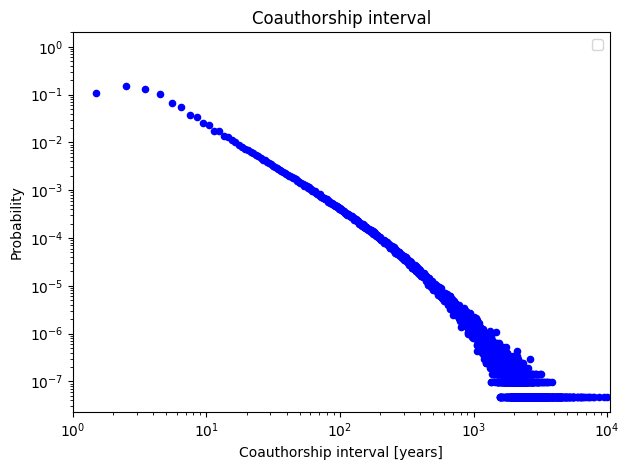

In [188]:
plotter(degrees["x"].values)

In [189]:
sorted = degrees.sort_values("x")
# sorted["x"]
# y= sorted["y"]
y= sorted["y"].cumsum()

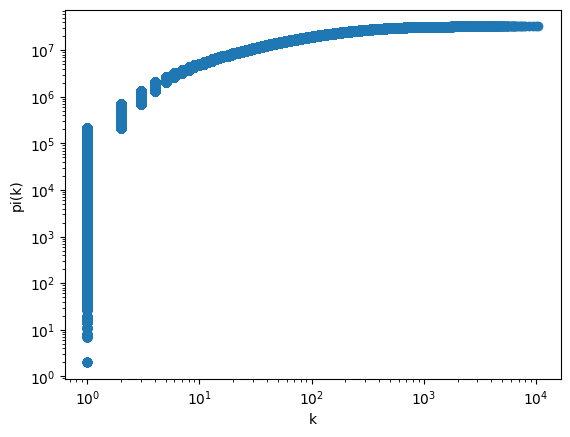

In [191]:
plt.scatter(sorted["x"], y)
# x = np.linspace(10**-1,max(sorted["x"]),50)
# C = max(y.loc[minx])
# y1 = np.log(x)*C/
# y2 = x*C/10**3
# plt.plot(x,y1)
# plt.plot(x,y2)
minx = min(sorted[sorted["x"]==20].index.values)
# plt.xlim(left=20)
# plt.ylim(bottom=max(y.loc[minx])/1.5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k")
plt.ylabel("pi(k)")
plt.show()

# Coauth probability

<Figure size 640x480 with 0 Axes>

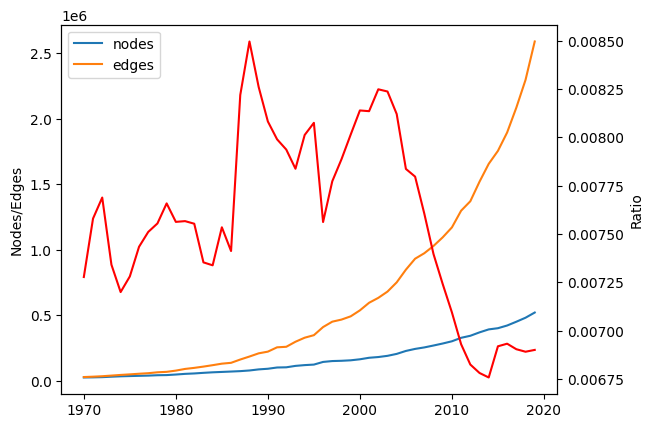

In [347]:
discs = ["PM" ] #"As","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]

year_range=range(1970,2020)
for disc in discs:
    coauth_success = pd.DataFrame()
    for i in year_range:
        with open(f'./result/coauth_pair_{disc}_{i}.pickle', 'rb') as f:
            coauth_pair = pickle.load(f)
        G = nx.Graph()
        G.add_edges_from(coauth_pair)
        new_line= {"nodes":len(G.nodes()), "edges":len(G.edges()),"num_coauth":len(coauth_pair), "ratio":len(G.edges())/len(G.nodes())**1.5}
        coauth_success = pd.concat([coauth_success, pd.DataFrame(new_line,index=[i])], axis="index")
    coauth_success.to_pickle(f"./result/coauth_success_{disc}.pickle")

    plt.clf()
    ax = coauth_success[["nodes","edges"]].plot()
    ax2 = ax.twinx()
    coauth_success["ratio"].plot(ax=ax2, color='r')
    
    ax.set_ylabel('Nodes/Edges')
    ax2.set_ylabel('Ratio')
    plt.show()

<Axes: >

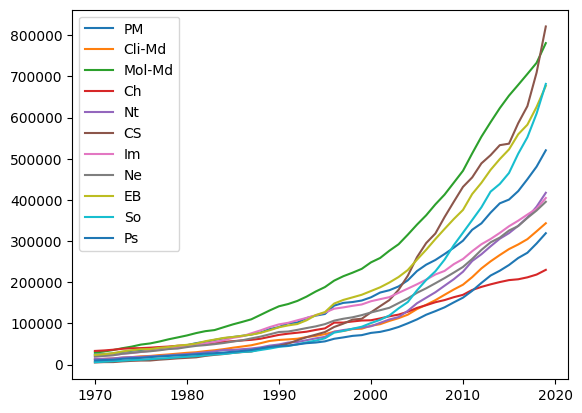

In [355]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]

s = pd.DataFrame()
for disc in discs:
    coauth_success = pd.read_pickle(f"./result/coauth_success_{disc}.pickle")
    # s[disc] = coauth_success["edges"] / coauth_success["nodes"]**1.5 # ==10^-2 -> q = edge/node^2 = edge/node^1.5 /node^0.5 = 10^-2 / node^0.5
    s[disc] = coauth_success["nodes"] # ==10^-2 -> q = edge/node^2 = edge/node^1.5 /node^0.5 = 10^-2 / node^0.5
s.plot()

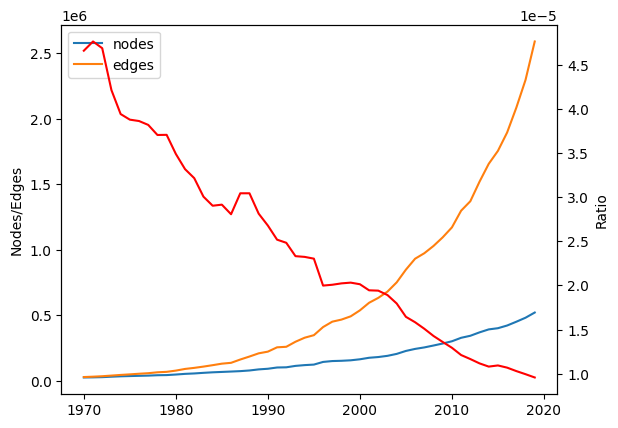

In [223]:
# Plotting "nodes" and "edges" columns
ax = coauth_success[["nodes","edges"]].plot()

# Creating a secondary y-axis for "ratio_3" column
ax2 = ax.twinx()
coauth_success["ratio"].plot(ax=ax2, color='r')

# Setting labels for y-axes
ax.set_ylabel('Edges/Nodes')
ax2.set_ylabel('Ratio in coauth matrix')

# Showing the plot
plt.show()

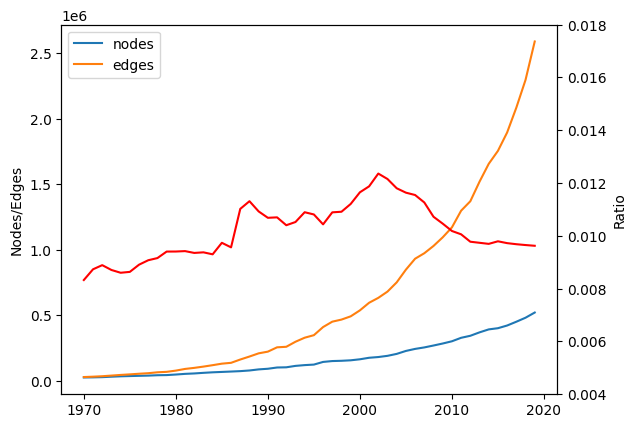

In [226]:
coauth_success["ratio_3"] = coauth_success["num_coauth"] / coauth_success["nodes"]**1.5
coauth_success
# Plotting "nodes" and "edges" columns
ax = coauth_success[["nodes","edges"]].plot()

# Creating a secondary y-axis for "ratio_3" column
ax2 = ax.twinx()
coauth_success["ratio_3"].plot(ax=ax2, color='r')

# Setting labels for y-axes
ax.set_ylabel('Edges/Nodes^1.5')
ax2.set_ylabel('Ratio ')
ax2.set_ylim(0.004,0.018)

# Showing the plot
plt.show()

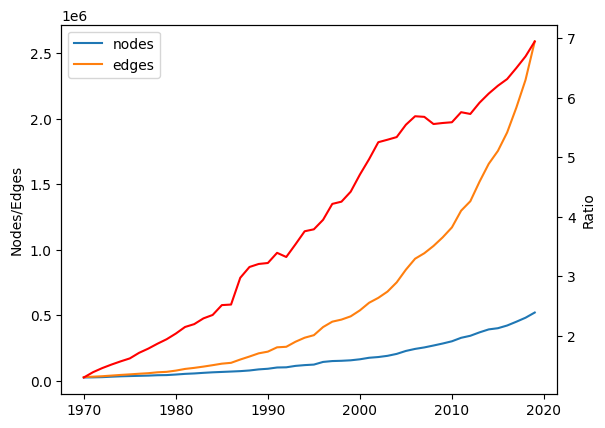

In [228]:
coauth_success["ratio"] = coauth_success["num_coauth"] / coauth_success["nodes"]
coauth_success
# Plotting "nodes" and "edges" columns
ax = coauth_success[["nodes","edges"]].plot()

# Creating a secondary y-axis for "ratio_3" column
ax2 = ax.twinx()
coauth_success["ratio"].plot(ax=ax2, color='r')

# Setting labels for y-axes
ax.set_ylabel('Edges/Nodes')
ax2.set_ylabel('Ratio (edges per researcher)')

# Showing the plot
plt.show()

## Coauth Matrix

In [589]:
from matplotlib.colors import Normalize

def priority_heatmap(priority_matrix):
    size = len(priority_matrix)//1000
    if size ==0: size = 1
    matrix = np.zeros((int(len(priority_matrix) / size),int(len(priority_matrix) / size)))
    for i in range(int(len(priority_matrix) / size)):
        for j in range(i+1, int(len(priority_matrix) / size)):
            sum = np.mean(priority_matrix[i:i+size, j:j+size])
            matrix[i][j] = sum
            matrix[j][i] = sum
    max_value = 0.1
    norm = Normalize(vmin=0, vmax=max_value, clip=True)
    plt.figure(figsize=(8, 6))

    plt.imshow(matrix, cmap='Reds', norm= norm,interpolation='nearest')
    # plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Coauthorship Density')
    plt.title(f'Coauthorship Adjacency Matrix {year}')
    plt.grid(False)
    plt.show()

In [320]:
def priority_heatmap(priority_matrix):
    size = 1000
    step = int(len(priority_matrix)/size)
    if step == 0: step =1
    matrix = np.zeros((size,size))
    
    for i in range(size):
        for j in range(i, size):
            mean = np.mean(priority_matrix[i*step:(i+1)*step,j*step:(j+1)*step]*10)
            matrix[i][j] = mean
            matrix[j][i] = mean
    plt.figure(figsize=(8, 6))
    
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Priority')
    plt.title('Priority Matrix Heatmap')
    plt.grid(False)
    plt.show()

In [585]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]

# for disc in discs:
disc = discs[0]
G=nx.Graph()
for year in  tqdm.tqdm(range(1970, 1990)):
    with open(f'./result/coauth_pair_{disc}_{year}.pickle', 'rb') as f:
        coauth_pair = pickle.load(f)
    G.add_edges_from(coauth_pair)
G

100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


283794 1094779 1.359314781542311e-05
10000 24248 0.00024248


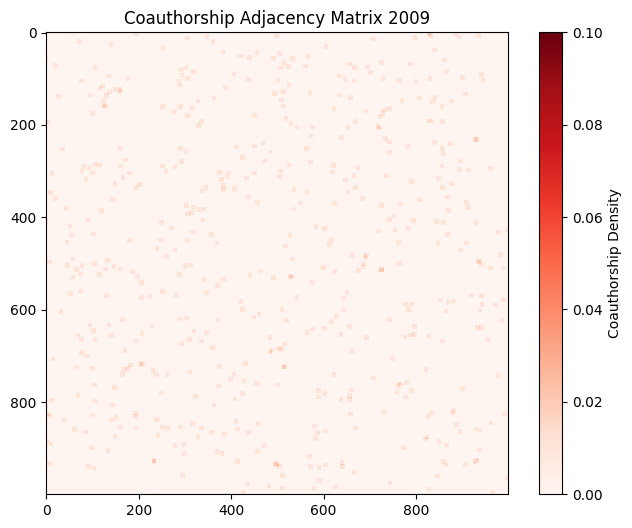

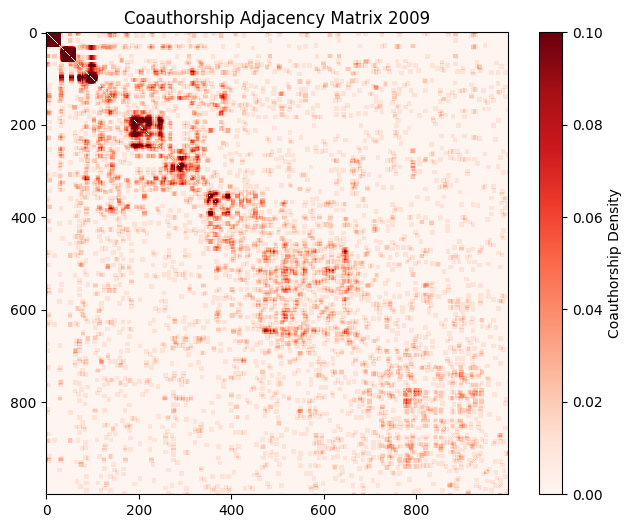

In [584]:
# subgraph_nodes = random.sample(list(G.nodes),10000)
subgraph_nodes = list(G.nodes)[:10000]
subgraph = G.subgraph(subgraph_nodes)

adj_matrix = nx.adjacency_matrix(subgraph)
# ノードを隣接行列でクラスタ化する
order = np.argsort(adj_matrix.sum(axis=0))

print(len(G.nodes()), len(G.edges()), len(G.edges()) / len(G.nodes())**2)
print(len(subgraph.nodes()), len(subgraph.edges()), len(subgraph.edges()) / len(subgraph.nodes())**2)

# クラスタ化された隣接行列を取得
clustered_adj_matrix = adj_matrix[order[::-1], :][:, order[::-1]]

priority_heatmap(adj_matrix.todense())
priority_heatmap(clustered_adj_matrix.todense())

In [395]:
year_df = pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/year.pickle")
year_df

eid
229021      1997
266363      1998
229022      1982
229023      1989
266364      1998
            ... 
26093078    1991
26106279    1991
26093079    1991
26106283    1991
26093080    1991
Name: year, Length: 78887776, dtype: int64

In [394]:
res = pd.read_pickle("./result/PM_100k.pickle")
res

authid  year  seq          eid  source_authid  previous_work
1     7005978840     0    1  84865749083    22834960500   8.486580e+10
1     6506350501     0    1  79551623906    25027822500   7.795643e+10
3     6508162666     0    1  79551623906    25027822500   7.795643e+10
4     6508162666     2    2  84869054803    25027822500   7.955162e+10
7     7003534425     0    1  79551623906    25027822500   7.795643e+10
..           ...   ...  ...          ...            ...            ...
472  57213855152     0    1     34848439    35459306800   3.584597e+07
473  57213855152     0    2     34832264    35459306800   3.484844e+07
474  57213855152     0    2        20557    35459306800   3.483226e+07
475  57213855152     2    4     37291254    35459306800   2.055700e+04
2    35748189000     0    1  85065526224    55828120300   8.506541e+10

[2451675 rows x 6 columns]

In [398]:
res = pd.merge(res, year_df, how="left", on="eid")

In [485]:
authors_valid = pd.read_pickle("./result/authors_valid_PM.pickle")
authors_valid

eid       authid  authseq         indexname        surname  \
165        85015329432  36620106200        1            Bae H.            Bae   
166        85015329432  56998595200        2           Bang T.           Bang   
167        85015329432   7409873371        3         Kim C.-K.            Kim   
168        85015329432  56194519000        4            Hur J.            Hur   
169        85015329432  57193625556        5            Kim S.            Kim   
...                ...          ...      ...               ...            ...   
289838959  84927731812  56887670500        4        Calvani P.        Calvani   
289838960  84927731812   6507192277        5      Trucchi D.M.        Trucchi   
289838961  84927731812   9332709800        2    Pietropaolo A.    Pietropaolo   
289839046  84927667476   7004157249        1  De Dios-Leyva M.  De Dios-Leyva   
289839047  84927667476  55173609100        2           Cuan R.           Cuan   

              givenname doctype  partition  
165             Hagyoul      ar        3.0  
166              Tewook      ar        3.0  
167           Choong-Ki      ar        3.0  
168                 Jae      ar        3.0  
169              Seyeob      ar        3.0  
...                 ...     ...        ...  
289838959  NO GIVENNAME      ar        3.0  
289838960  NO GIVENNAME      ar        3.0  
289838961  NO GIVENNAME      ar        3.0  
289839046  NO GIVENNAME      ar        3.0  
289839047  NO GIVENNAME      ar        3.0  

[22084638 rows x 8 columns]

In [486]:
authors_valid["authid"].nunique()

3216696

In [484]:
res["eid"].nunique()

744139

In [477]:
sample = res[res["source_authid"]==55422199300]
sample["year_x"].value_counts()

0     9108
1     1523
2      118
3       61
4       30
5       18
6       13
8        9
7        6
10       5
9        3
13       2
12       2
16       1
19       1
14       1
Name: year_x, dtype: int64

In [480]:
sample[sample["year_x"] == 14]["year_y"].value_counts()
# res[(res["source_authid"]==55422199300) & (res["year_y"] == 2021)]["authid"].unique() #["year_y"].value_counts()

2010    1
Name: year_y, dtype: int64

In [460]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]
disc = discs[0] # PM
year_range = [2021] #range(1970,2010)

def drawmatrix(m):
    for i in range(m.shape[0]):
        for j in range(i+1, m.shape[0]):
            sum = np.max(m)
            matrix[i][j] = sum
            matrix[j][i] = sum
    max_value = matrix.max()
    norm = Normalize(vmin=0, vmax=max_value, clip=True)
    plt.figure(figsize=(8, 6))

    plt.imshow(matrix, cmap='hot', norm= norm,interpolation='nearest')
    # plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Coauthorship Density')
    plt.title(f'Coauthorship Adjacency Matrix {year}')
    plt.grid(False)
    plt.show()
# auth = res["source_authid"].unique()
# print(res.groupby("source_authid")["authid"].count().sort_values(ascending= False).head())
# 単回
for year in year_range:
    print(year)
    interval = res.query(f"year_y=={year} and source_authid==55422199300")[["authid","year_x","source_authid"]]
    if len(interval["authid"].unique())<=1: print("aaa");continue
    with open(f'./result/coauth_pair_{disc}_{year}.pickle', 'rb') as f:
        coauth_pair = pickle.load(f)
    
    G=nx.Graph()
    G.add_edges_from(coauth_pair)
    
    # subgraph_nodes = random.sample(list(G.nodes),10000)
    se = pd.Series(G.nodes)
    subgraph_nodes = se[se.index.isin(interval["authid"].unique())].index.values
    # print(subgraph_nodes)
    subgraph = G.subgraph(subgraph_nodes)
    
    adj_matrix = nx.adjacency_matrix(subgraph)
    order = np.argsort(adj_matrix.sum(axis=0))

    print(adj_matrix)
    interval_matrix = np.zeros((adj_matrix.shape[0],adj_matrix.shape[0]))
    for i in range(adj_matrix.shape[0]):
        interval_matrix[i] = np.max(interval[interval["authid"]==subgraph_nodes[i]]["year_x"])
            
    print(interval_matrix)
    clustered_adj_matrix = adj_matrix[order[::-1], :][:, order[::-1]]
    clustered_interval = interval_matrix[order[::-1],:][:, order[::-1]]
    # print(clustered_adj_matrix.shape[0])
    # priority_heatmap(adj_matrix.todense())
    # priority_heatmap(clustered_adj_matrix.todense())
    drawmatrix(clustered_adj_matrix)
    drawmatrix(clustered_interval)

2021
aaa


In [591]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]
disc = discs[0] # Cli-Md
year_range = range(1970,2010)

# 累積、ランダム
for year in year_range:
    with open(f'./result/coauth_pair_{disc}_{year}.pickle', 'rb') as f:
        coauth_pair = pickle.load(f)
    
    G=nx.Graph()
    G.add_edges_from(coauth_pair)
    
    # subgraph_nodes = random.sample(list(G.nodes),1000)
    subgraph_nodes = list(G.nodes)[:1000]
    subgraph = G.subgraph(subgraph_nodes)
    
    adj_matrix = nx.adjacency_matrix(subgraph)
    order = np.argsort(adj_matrix.sum(axis=0))
    
    clustered_adj_matrix = adj_matrix[order[::-1], :][:, order[::-1]]
    
    # priority_heatmap(adj_matrix.todense())
    priority_heatmap(clustered_adj_matrix.todense())

KeyboardInterrupt: 

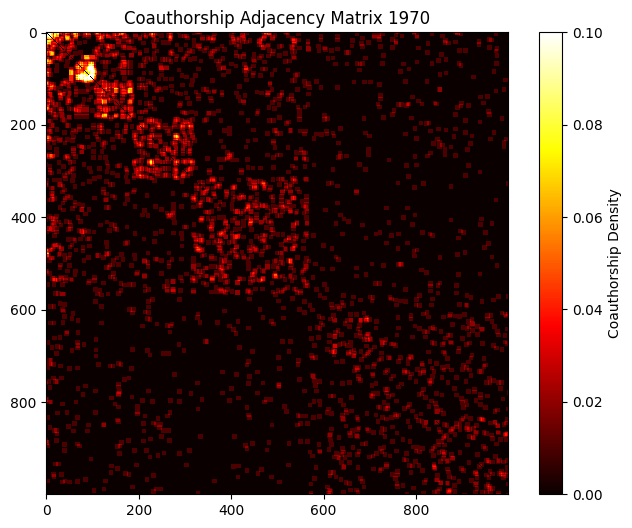

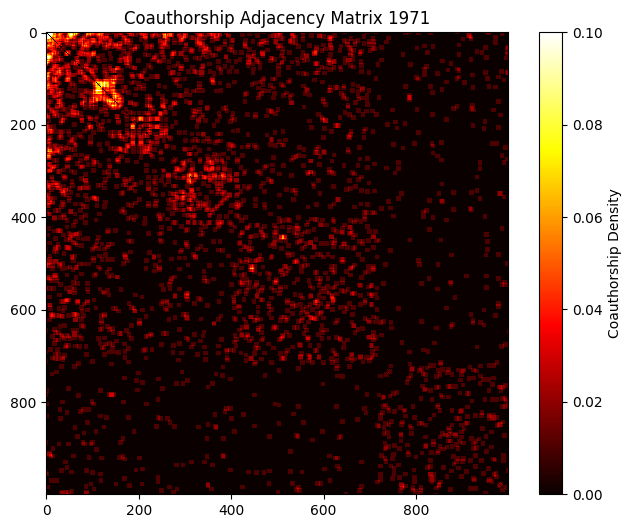

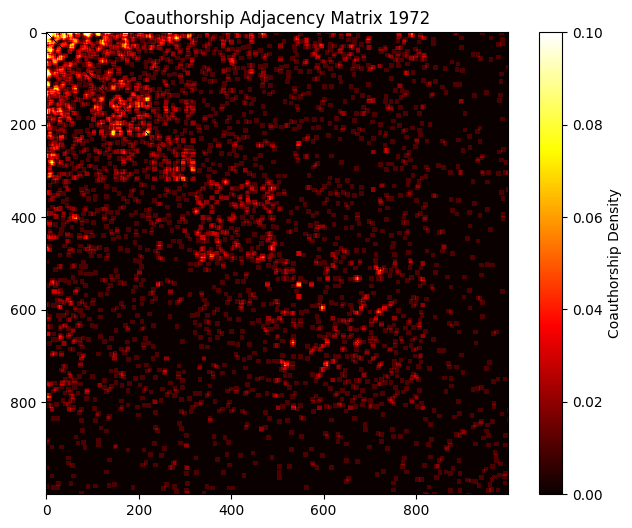

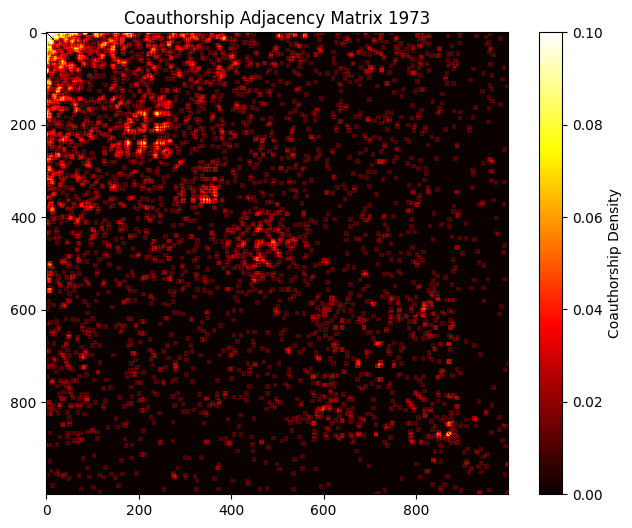

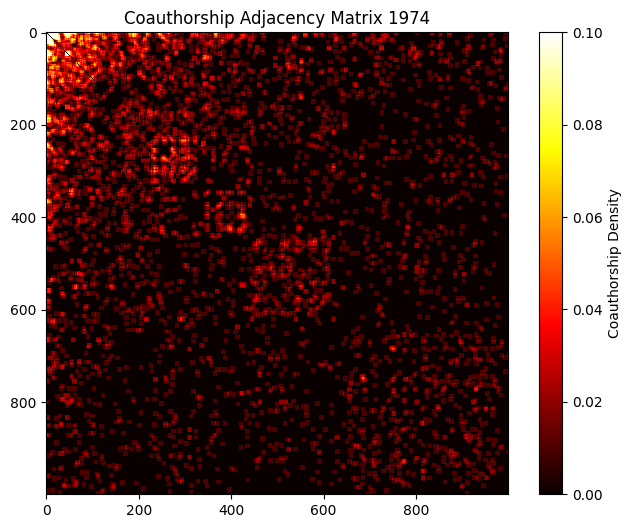

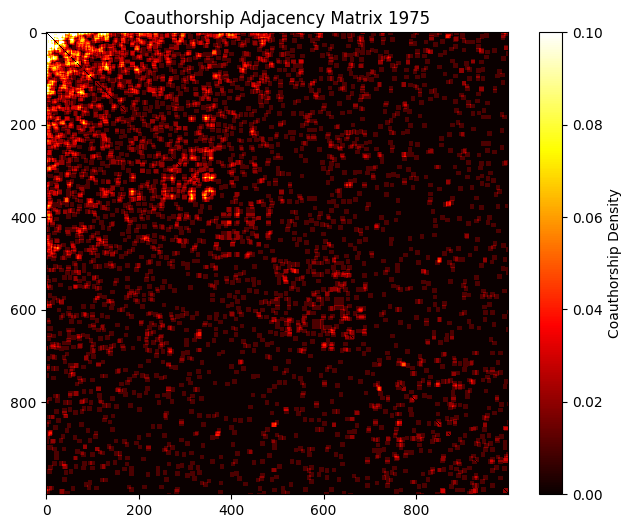

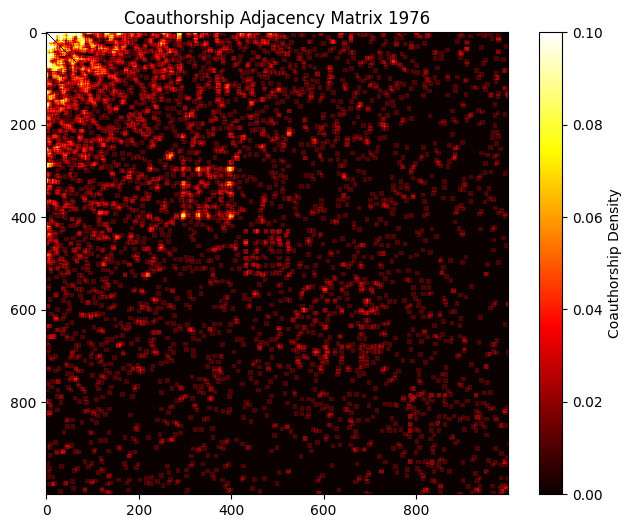

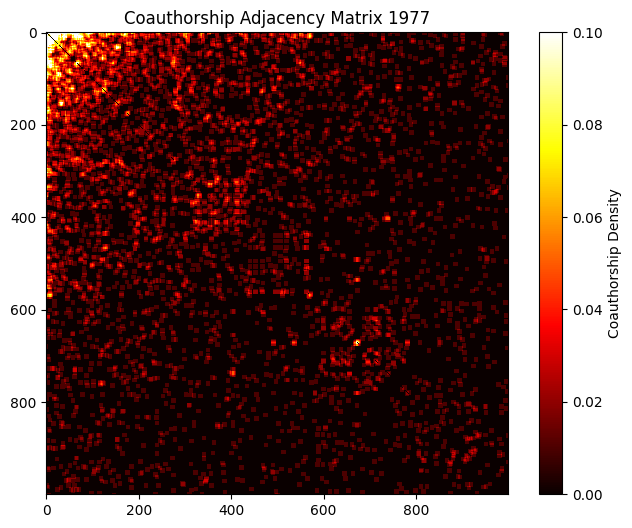

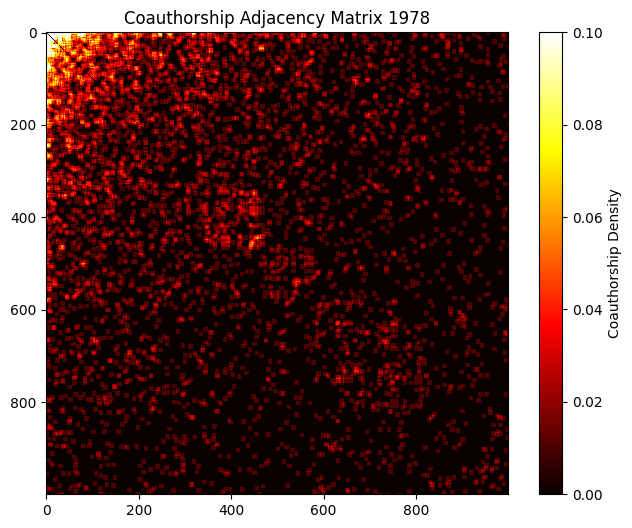

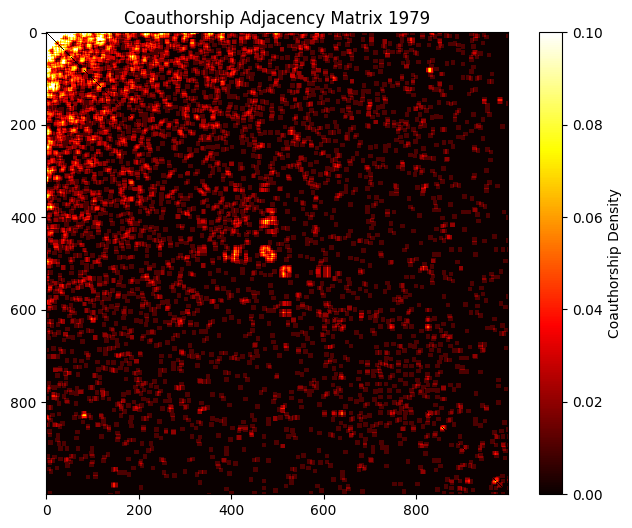

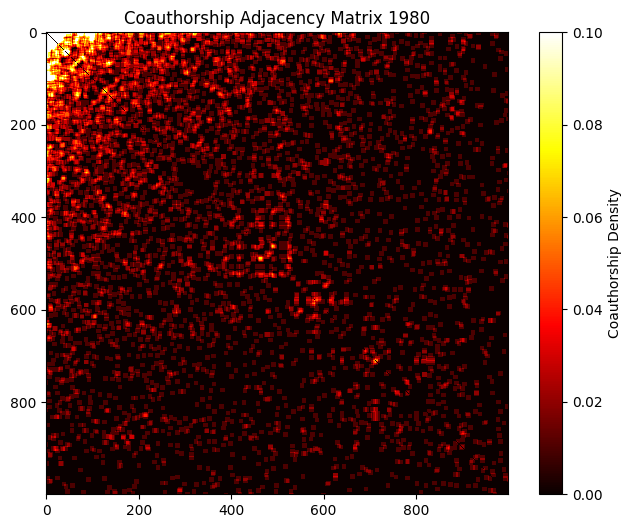

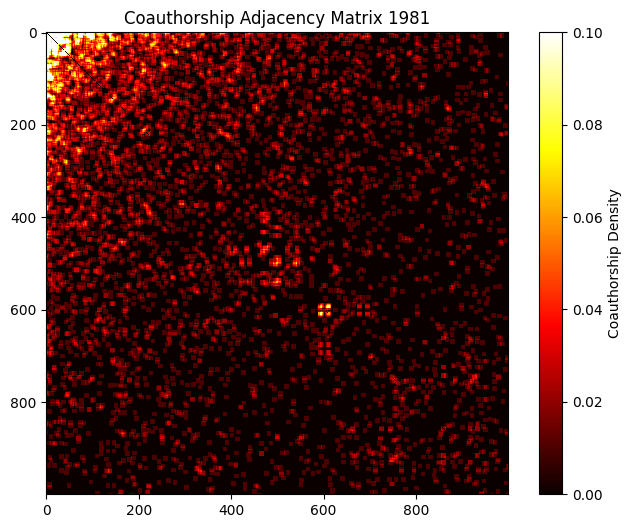

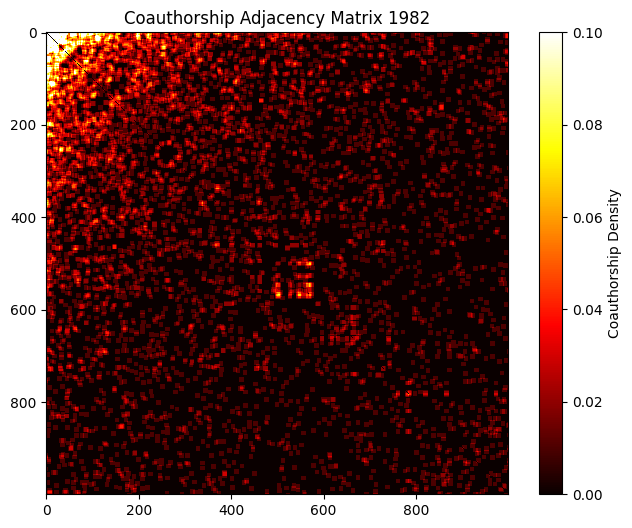

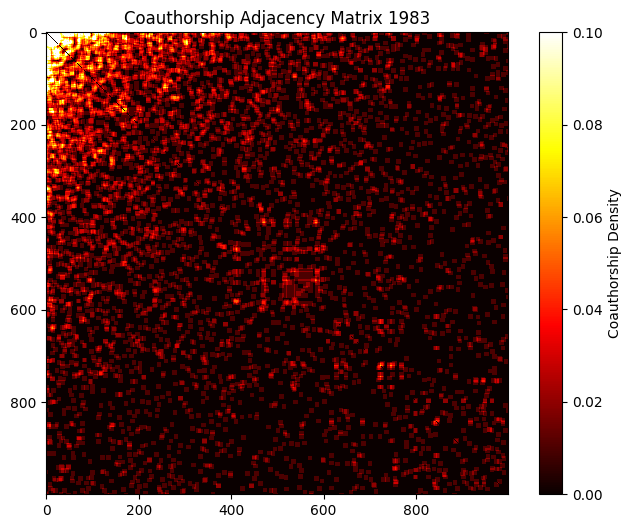

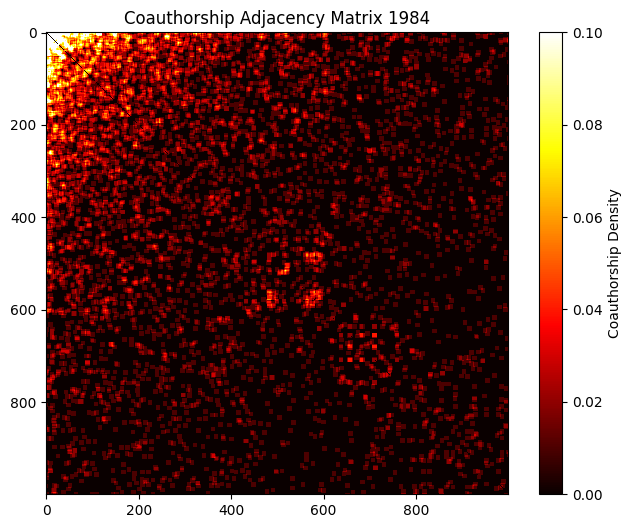

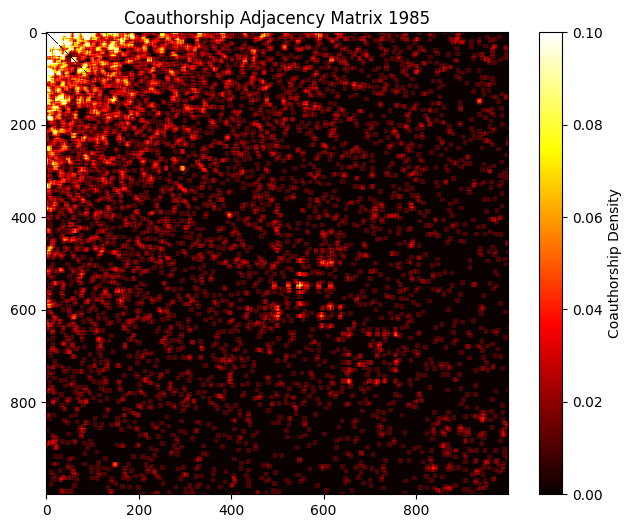

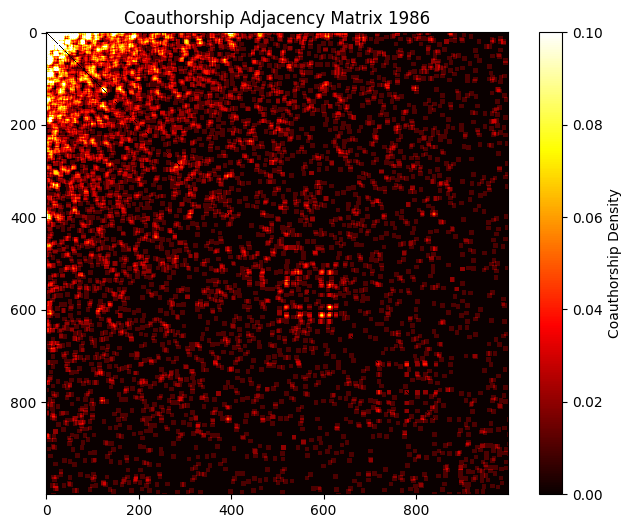

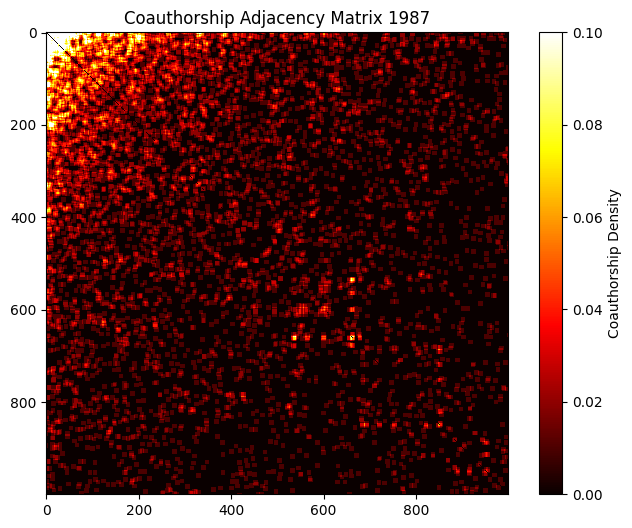

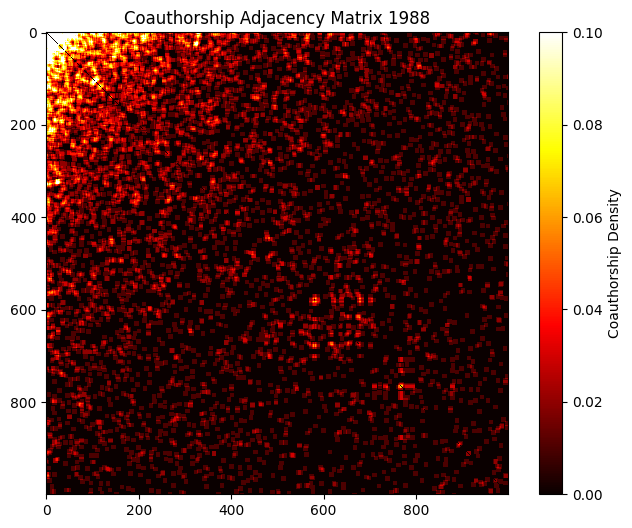

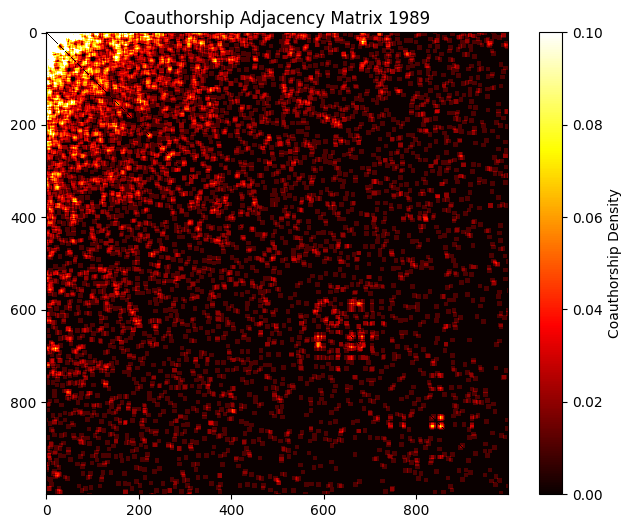

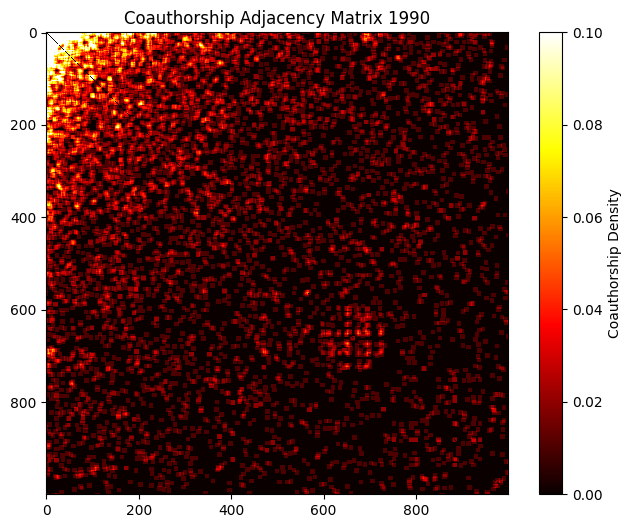

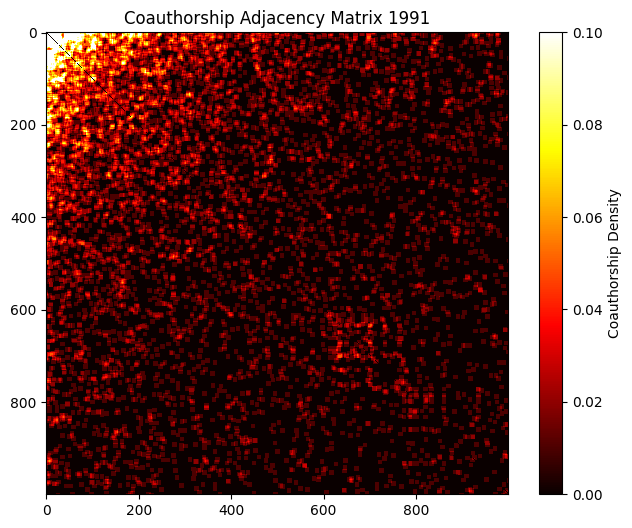

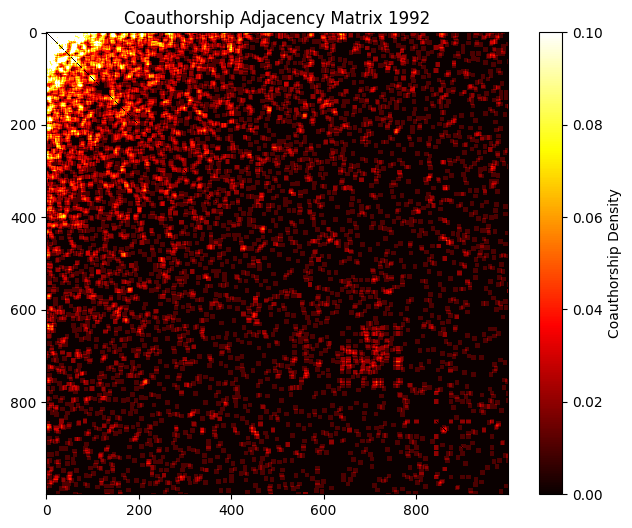

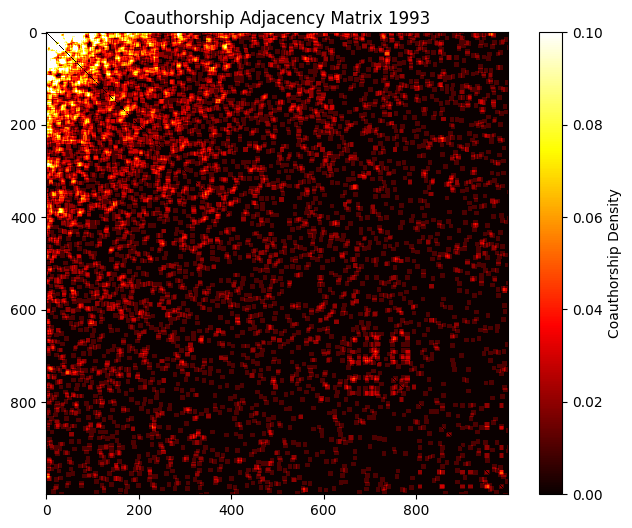

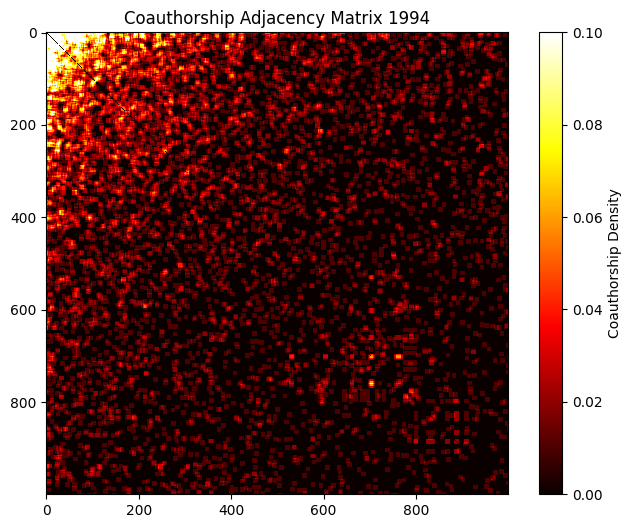

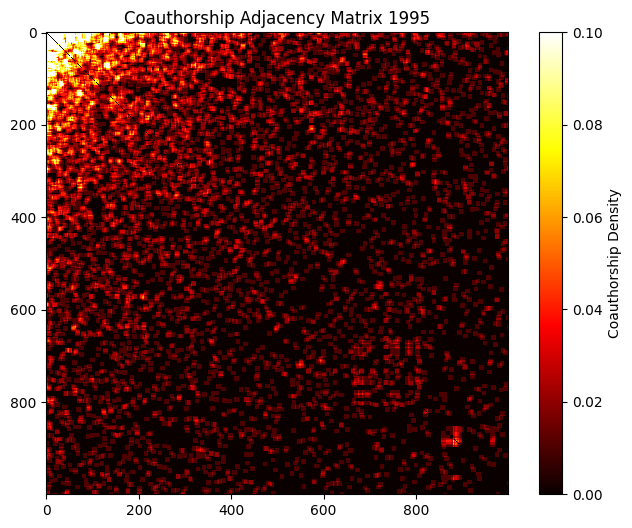

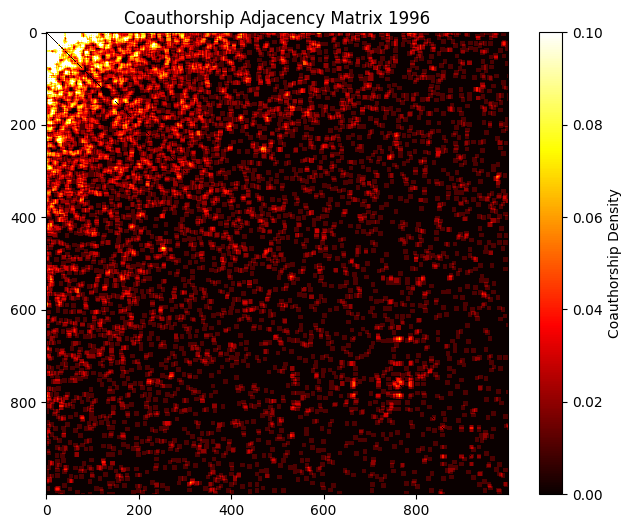

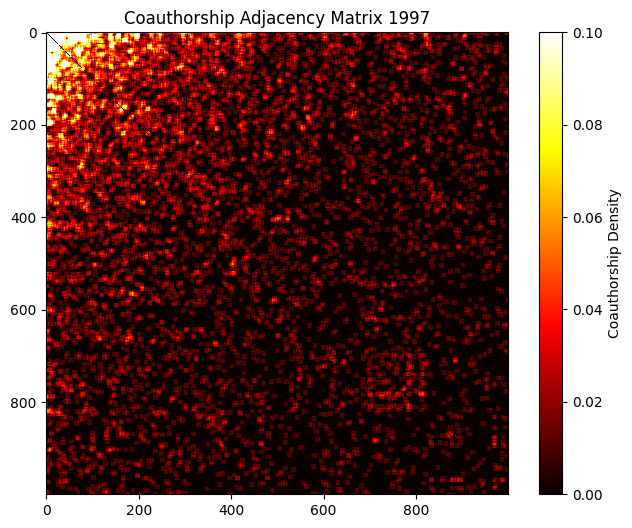

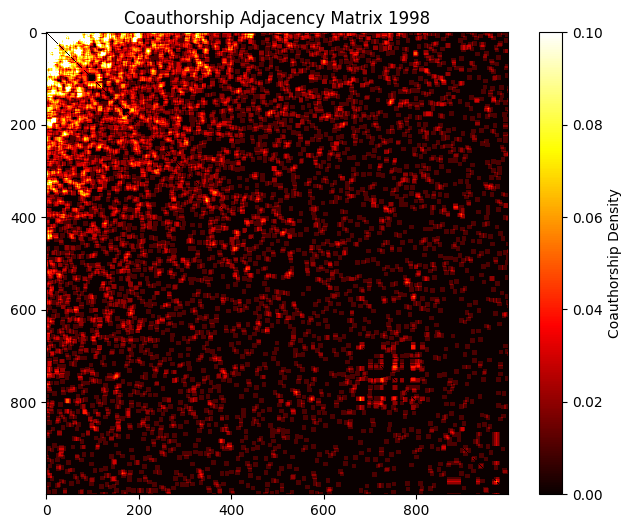

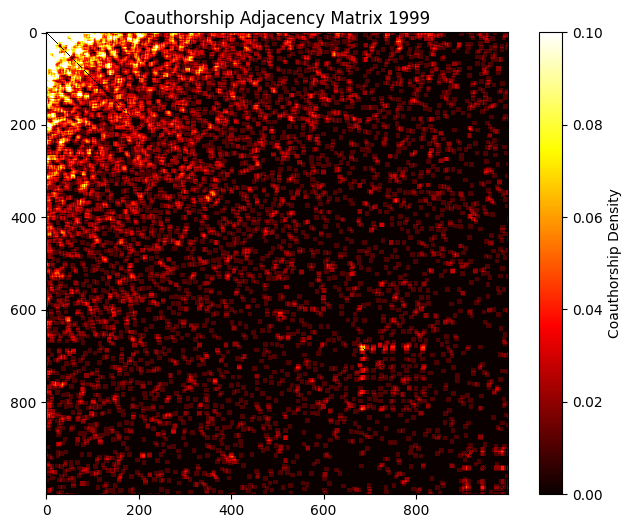

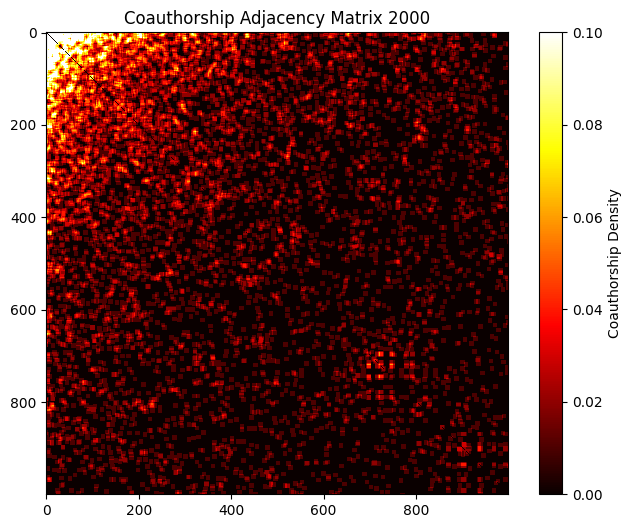

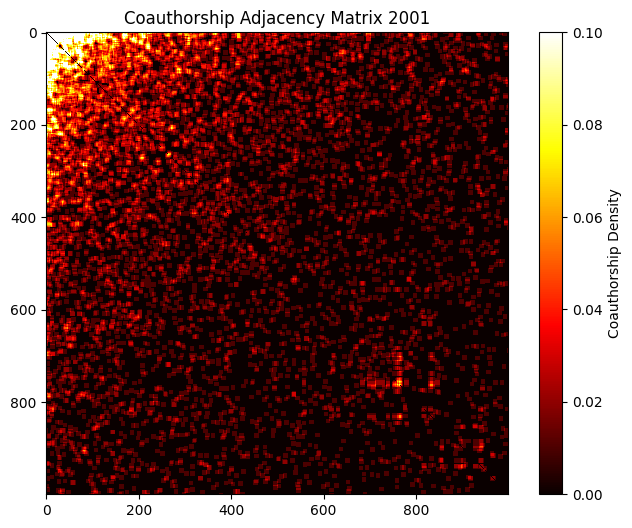

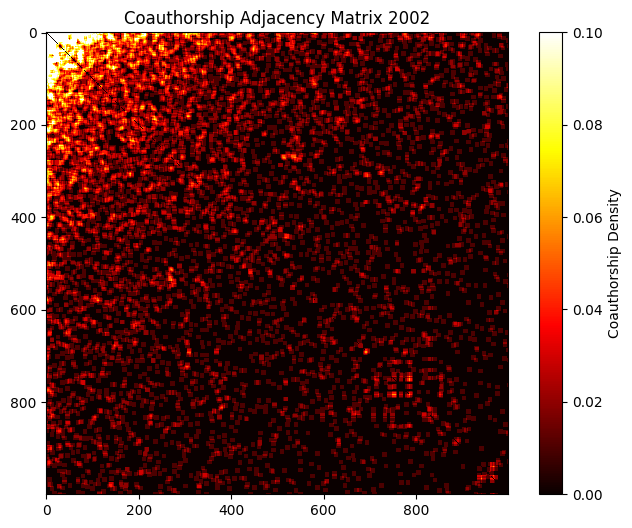

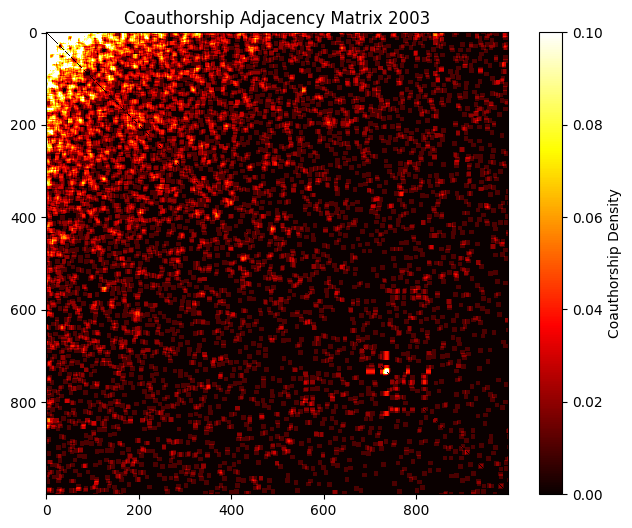

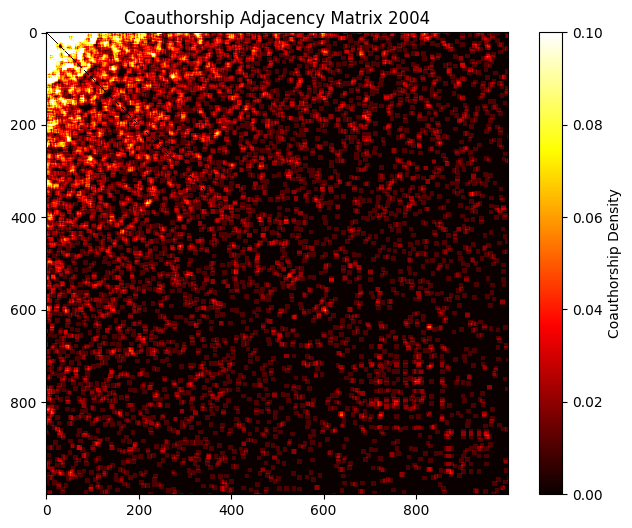

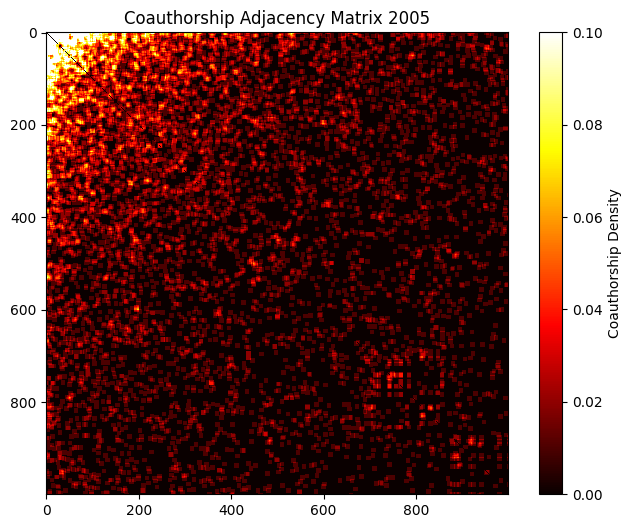

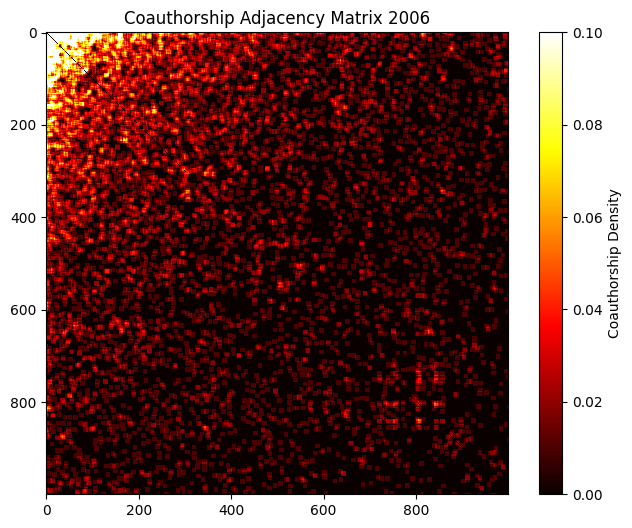

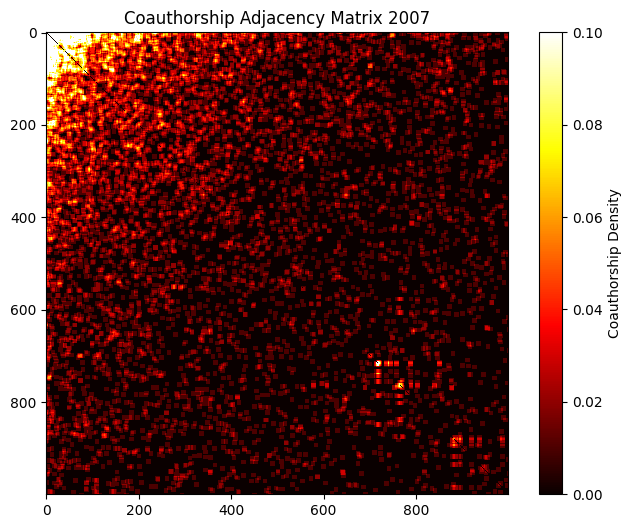

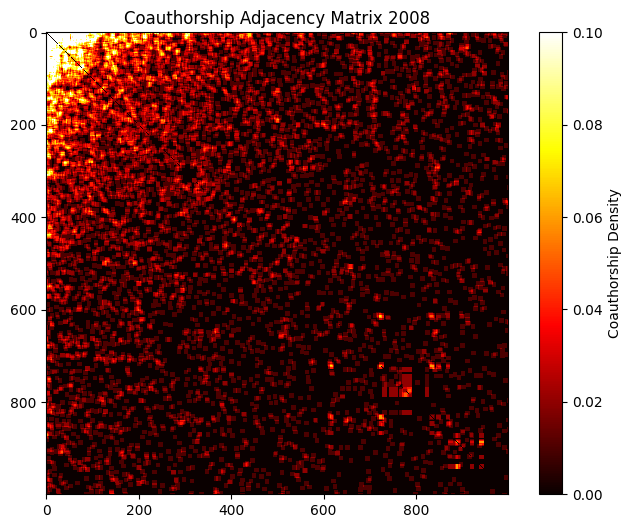

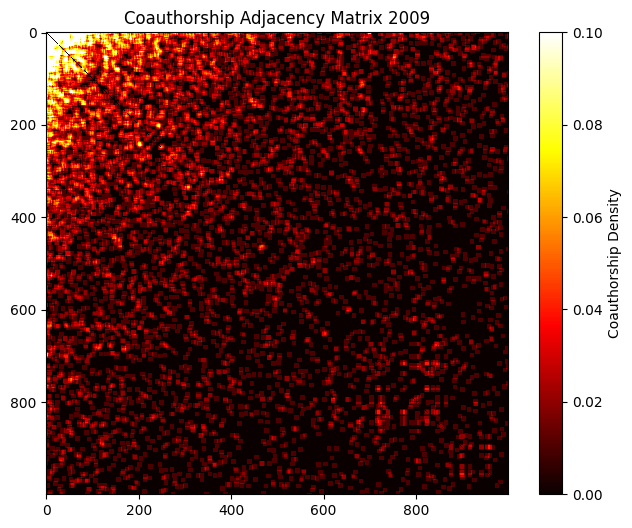

In [389]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]
disc = discs[0] # Cli-Md
year_range = range(1970,2010)

# 累積、上位
G=nx.Graph()
for year in year_range:
    with open(f'./result/coauth_pair_{disc}_{year}.pickle', 'rb') as f:
        coauth_pair = pickle.load(f)
    G.add_edges_from(coauth_pair)
    
    # subgraph_nodes = random.sample(list(G.nodes),10000)
    subgraph_nodes = list(G.nodes)[:10000]
    subgraph = G.subgraph(subgraph_nodes)
    
    adj_matrix = nx.adjacency_matrix(subgraph)
    order = np.argsort(adj_matrix.sum(axis=0))
    
    clustered_adj_matrix = adj_matrix[order[::-1], :][:, order[::-1]]
    
    # priority_heatmap(adj_matrix.todense())
    priority_heatmap(clustered_adj_matrix.todense())

In [579]:
import igraph as ig
import leidenalg as la

# create a graph
# g = ig.Graph.Famous('Zachary')

# find the clusters
part = la.find_partition(G, la.ModularityVertexPartition)

# print the clusters
for cluster in part:
    print(cluster)

AttributeError: 'Graph' object has no attribute 'vcount'

## coauth_cluster

(10000, 10000)


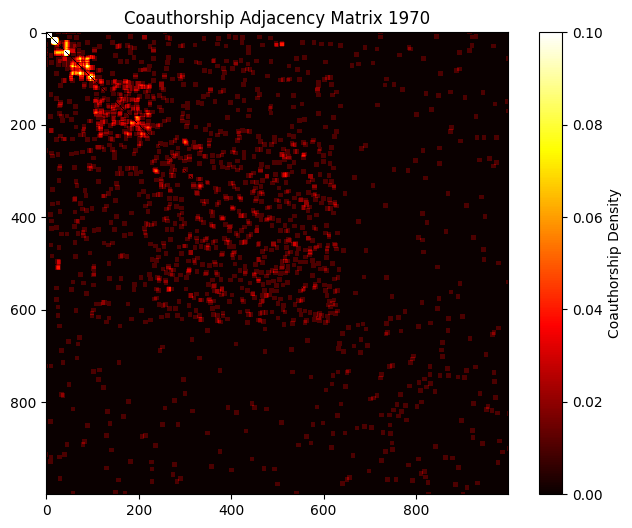

(3095, 3095)


IndexError: index (9999) out of range

In [491]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]
disc = discs[0] # Cli-Md
year_range = range(1970,2010)

# 累積、上位

with open(f'./result/coauth_pair_{disc}_1970.pickle', 'rb') as f:
    coauth_pair = pickle.load(f)
G.add_edges_from(coauth_pair)
    
subgraph_nodes = random.sample(list(G.nodes),10000)
subgraph = G.subgraph(subgraph_nodes)
adj_matrix = nx.adjacency_matrix(subgraph)
order = np.argsort(adj_matrix.sum(axis=0))

for year in year_range:
    with open(f'./result/coauth_pair_{disc}_{year}.pickle', 'rb') as f:
        coauth_pair = pickle.load(f)
        
    G=nx.Graph()
    G.add_edges_from(coauth_pair)
    
    subgraph = G.subgraph(subgraph_nodes)
    adj_matrix = nx.adjacency_matrix(subgraph)

    print(adj_matrix.shape)
    clustered_adj_matrix = adj_matrix[order[::-1], :][:, order[::-1]]
    
    # priority_heatmap(adj_matrix.todense())
    priority_heatmap(clustered_adj_matrix.todense())

In [494]:
discs = ["PM","Cli-Md","Mol-Md","Ch","Nt","CS","Im","Ne","EB","So","Ps"]
disc = discs[0] #
year_range = range(1970,2010)

res = pd.read_pickle(f"./result/{disc}_100k.pickle")
year_df = pd.read_pickle("/disks/qnap2/shared/scopus_2022/paper_detail/year.pickle")
res = pd.merge(res, year_df, how= "left", on="eid")

In [496]:
res

authid  year_x  seq          eid  source_authid  previous_work  \
0         7005978840       0    1  84865749083    22834960500   8.486580e+10   
1         6506350501       0    1  79551623906    25027822500   7.795643e+10   
2         6508162666       0    1  79551623906    25027822500   7.795643e+10   
3         6508162666       2    2  84869054803    25027822500   7.955162e+10   
4         7003534425       0    1  79551623906    25027822500   7.795643e+10   
...              ...     ...  ...          ...            ...            ...   
2451670  57213855152       0    1     34848439    35459306800   3.584597e+07   
2451671  57213855152       0    2     34832264    35459306800   3.484844e+07   
2451672  57213855152       0    2        20557    35459306800   3.483226e+07   
2451673  57213855152       2    4     37291254    35459306800   2.055700e+04   
2451674  35748189000       0    1  85065526224    55828120300   8.506541e+10   

         year_y  
0          2012  
1          2010  
2          2010  
3          2012  
4          2010  
...         ...  
2451670    2001  
2451671    2001  
2451672    2001  
2451673    2003  
2451674    2019  

[2451675 rows x 7 columns]

In [547]:
sample

authid  year_x  seq          eid  source_authid  previous_work  \
366       6507895583       2    1     16725915     7006333491   1.635914e+07   
367       6507895583       0    1     16871569     7006333491   1.672592e+07   
371       6603668422       2    1     16725915     7006333491   1.635914e+07   
372       6603668422       0    1     16871569     7006333491   1.672592e+07   
396       7003768921       2    1     16725915     7006333491   1.635914e+07   
...              ...     ...  ...          ...            ...            ...   
2447841  35478642300       1    1    542399496    56293092500   1.650955e+07   
2447842  35478642300       0    1     12446105    56293092500   5.423995e+08   
2448606  55728406100       0    1     16870725    56315421700   1.731189e+07   
2450428  15134520700       1    1  36749115792    22970416800   3.674911e+10   
2450438  16407168500       1    1  36749115792    22970416800   3.674911e+10   

         year_y  
366        1976  
367        1976  
371        1976  
372        1976  
396        1976  
...         ...  
2447841    1976  
2447842    1976  
2448606    1976  
2450428    1976  
2450438    1976  

[1666 rows x 7 columns]

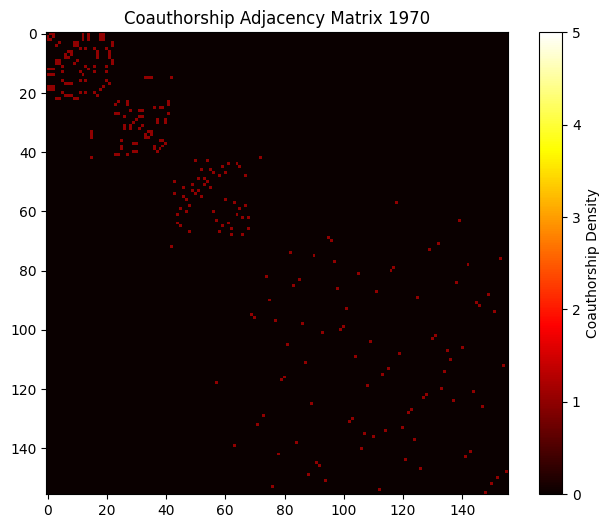

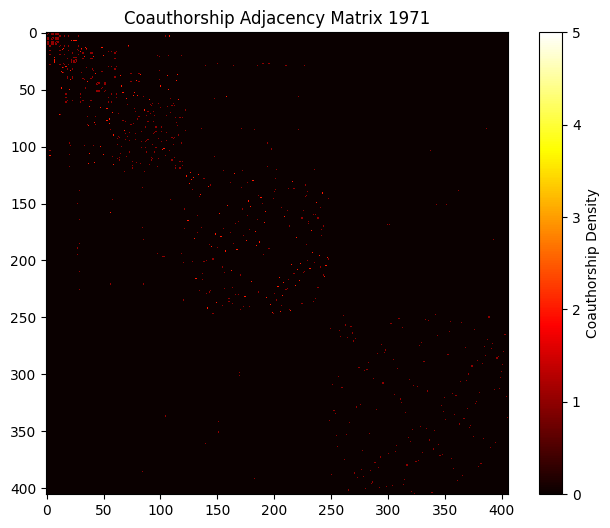

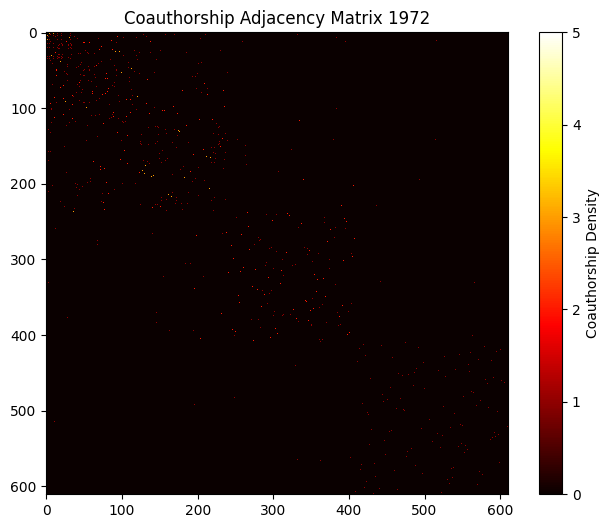

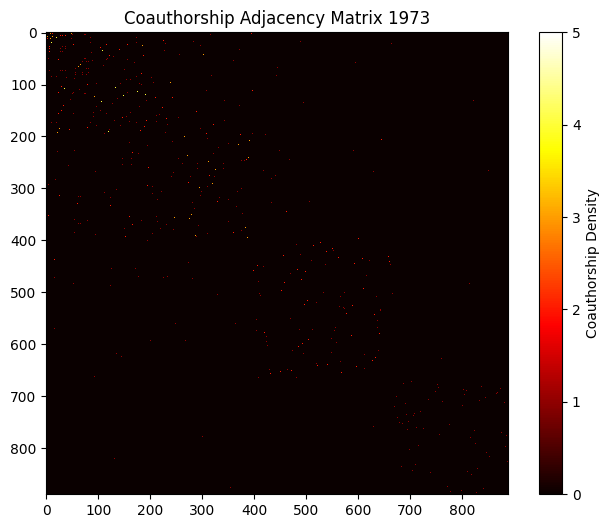

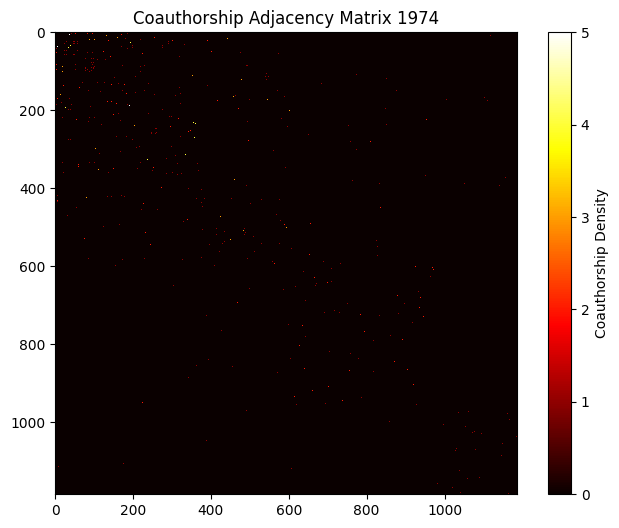

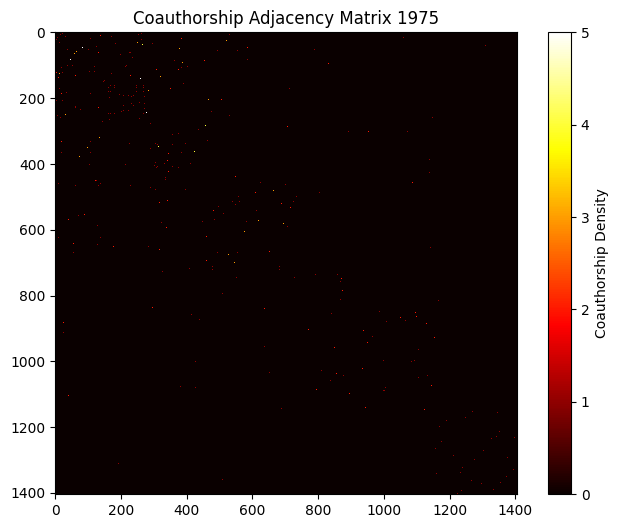

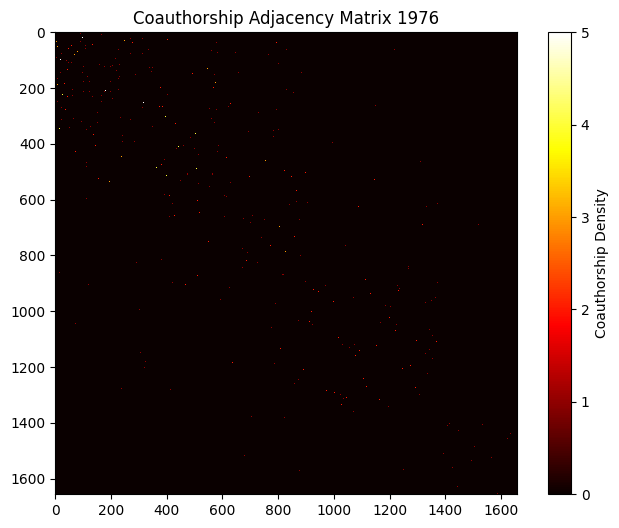

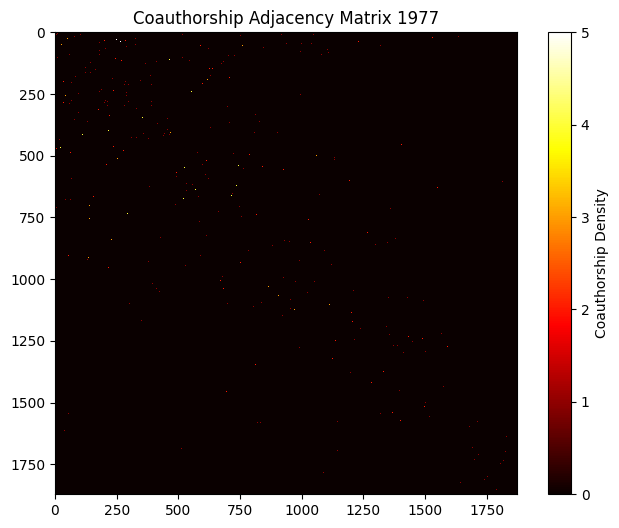

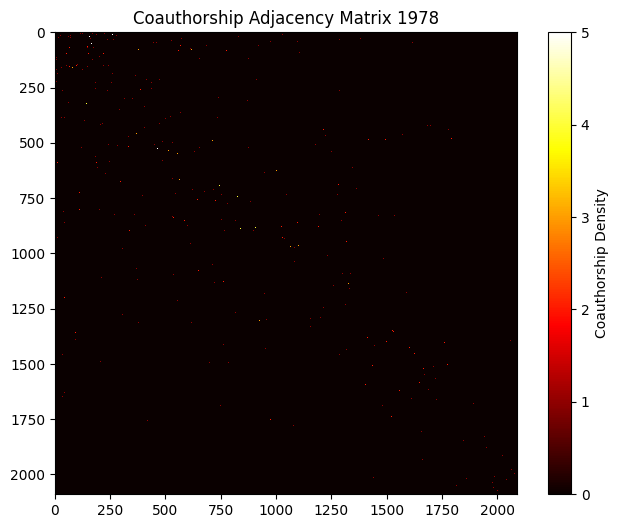

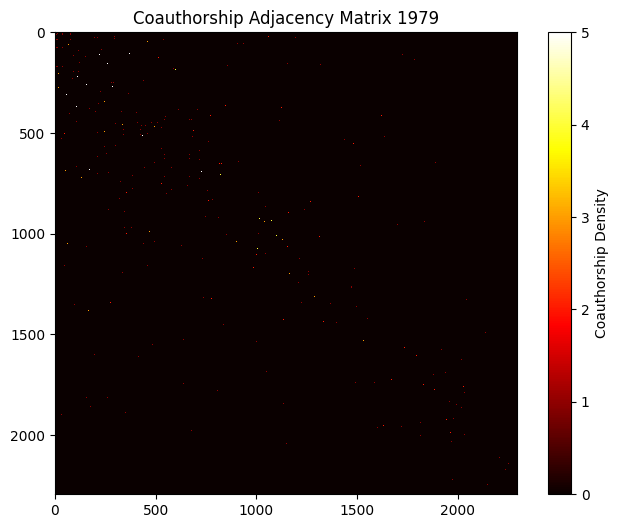

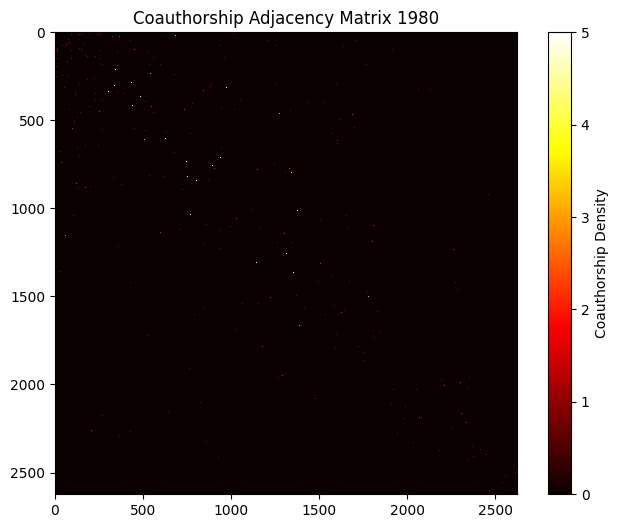

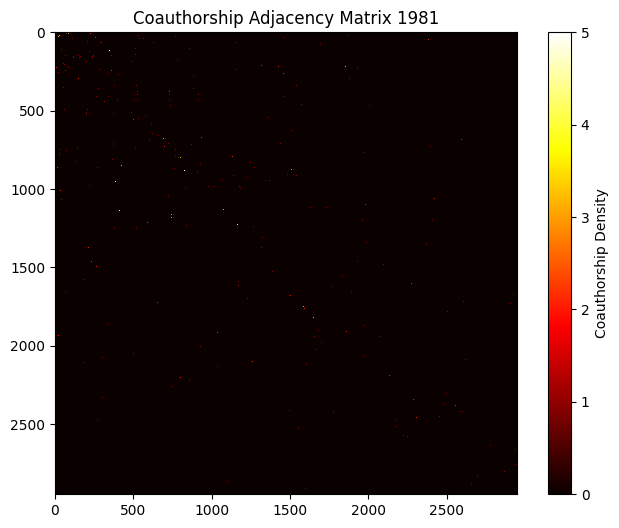

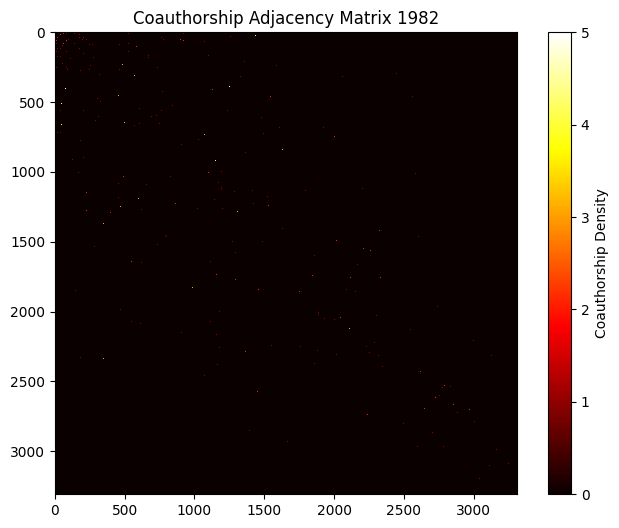

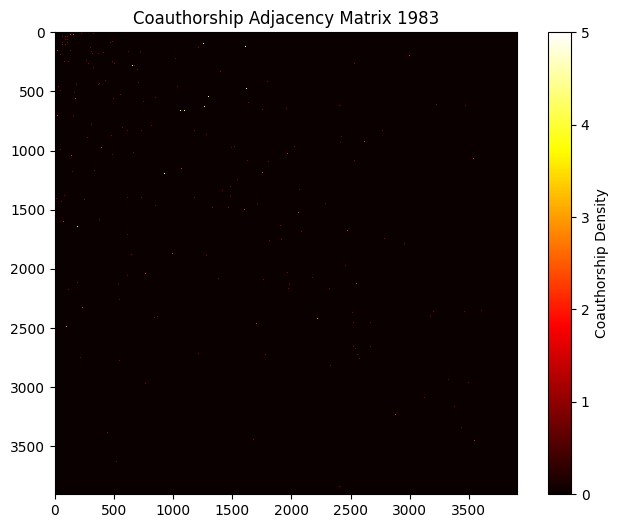

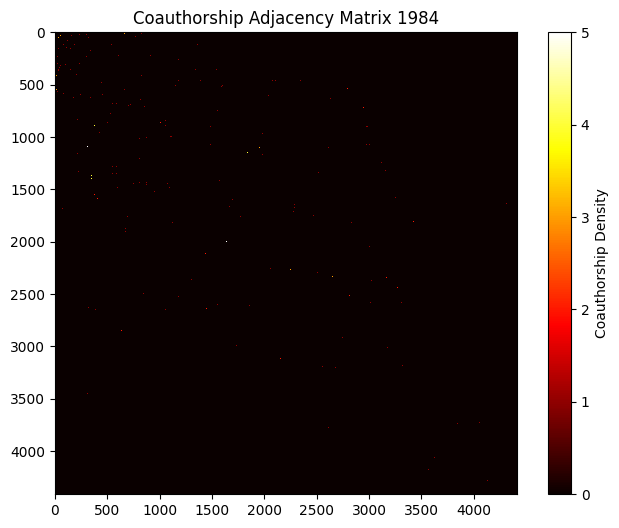

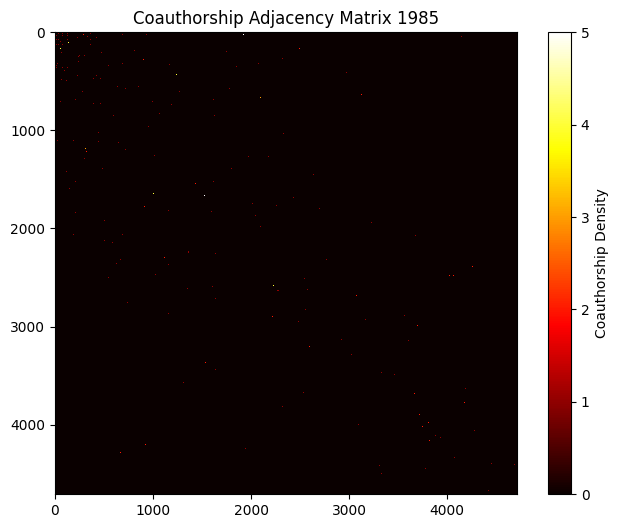

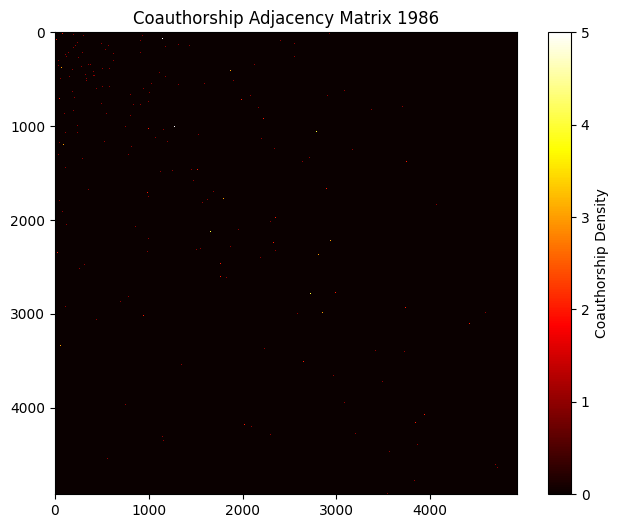

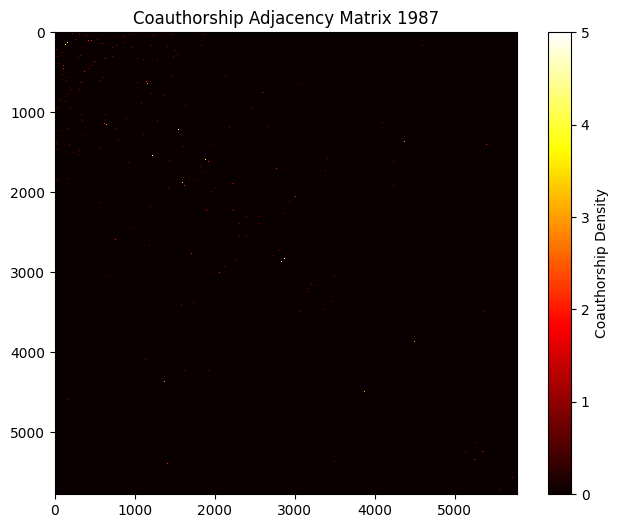

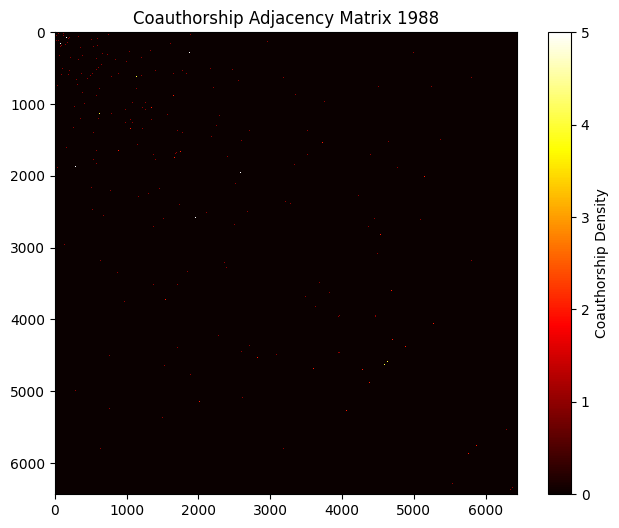

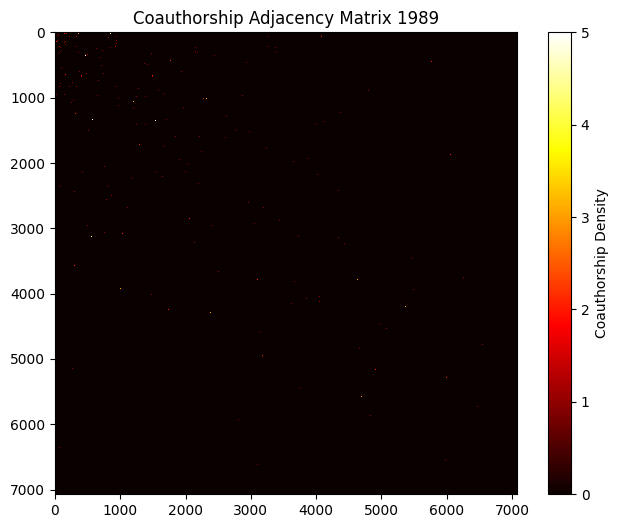

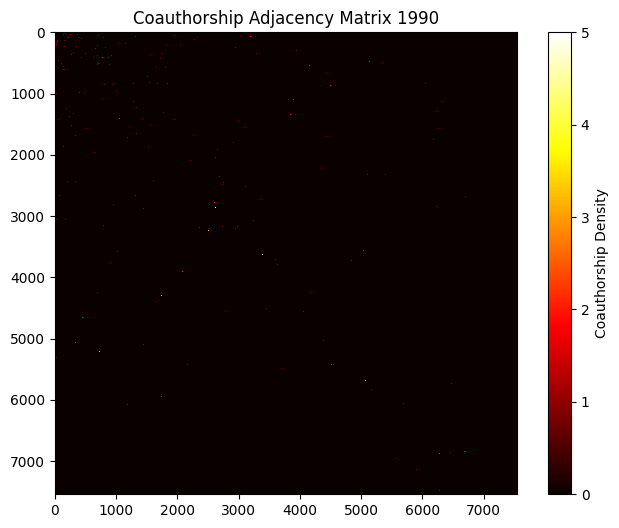

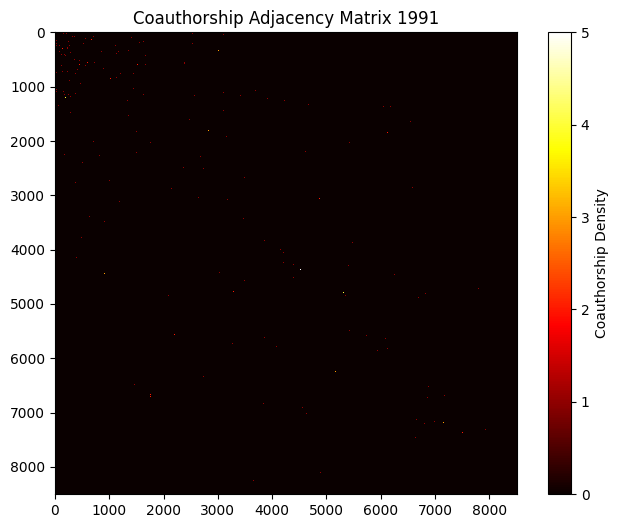

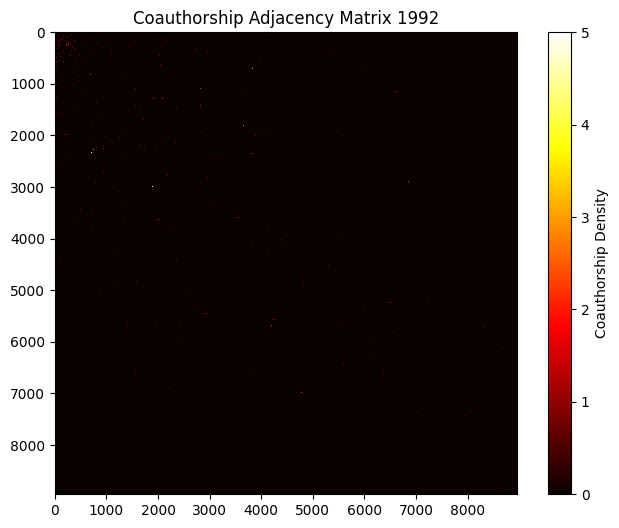

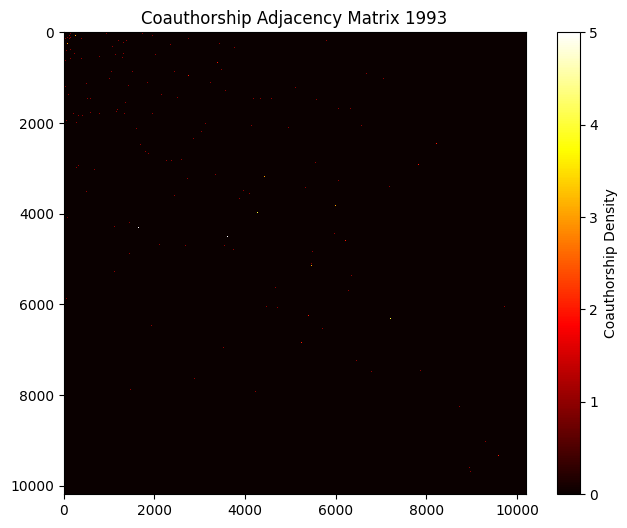

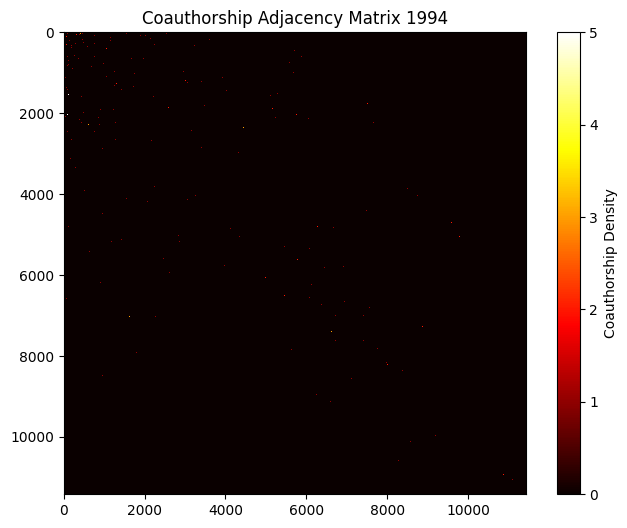

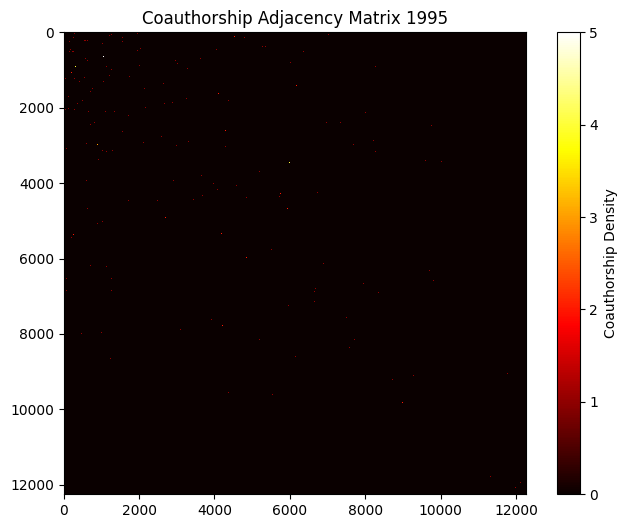

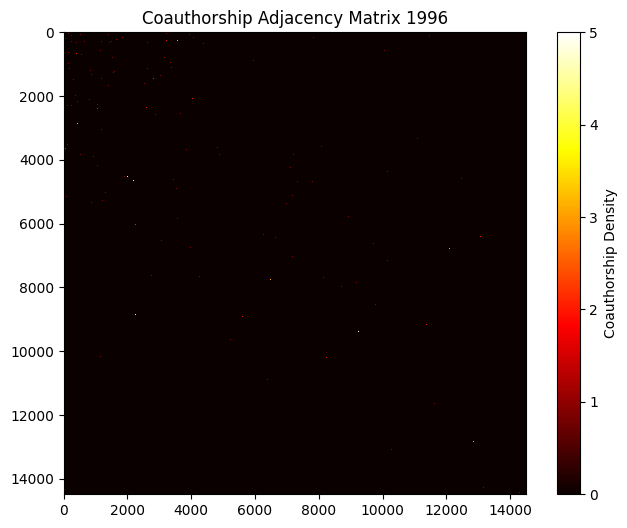

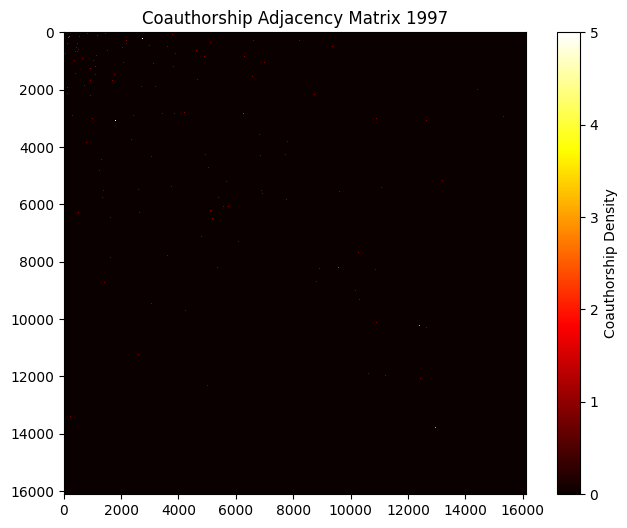

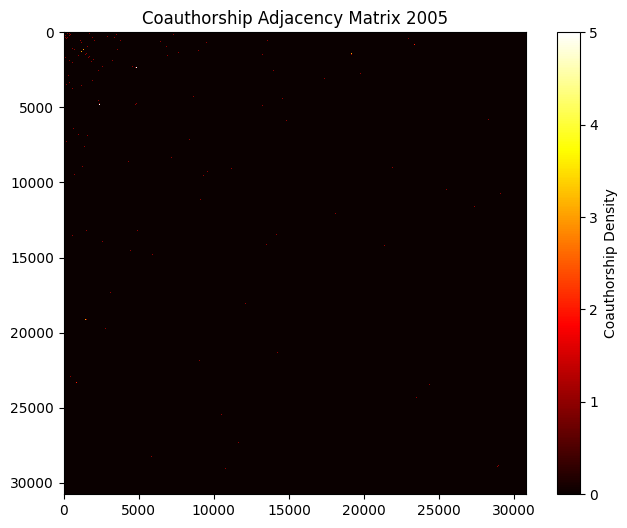

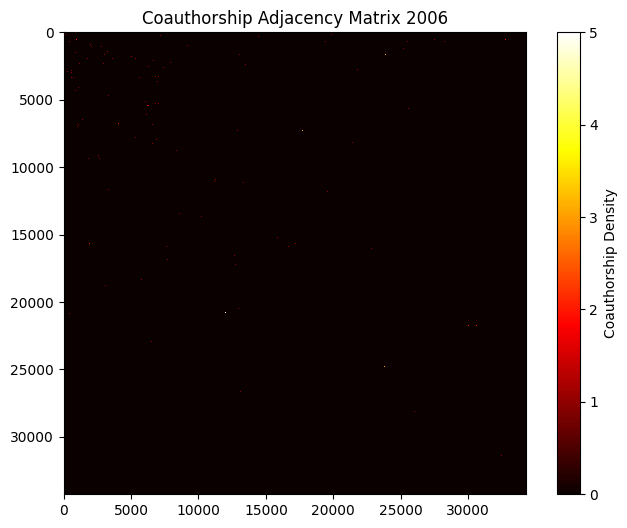

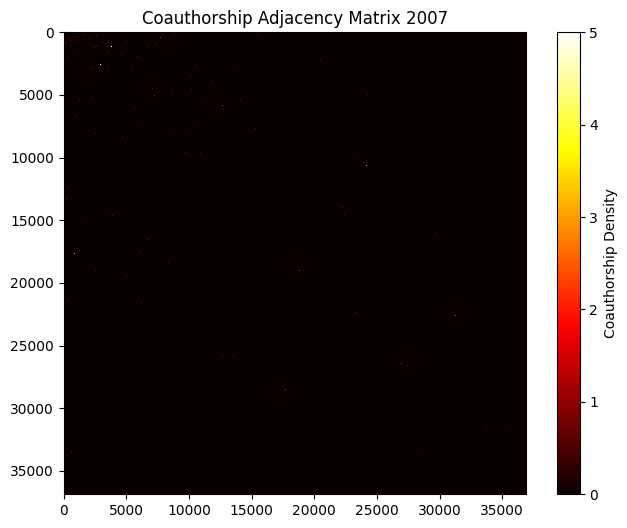

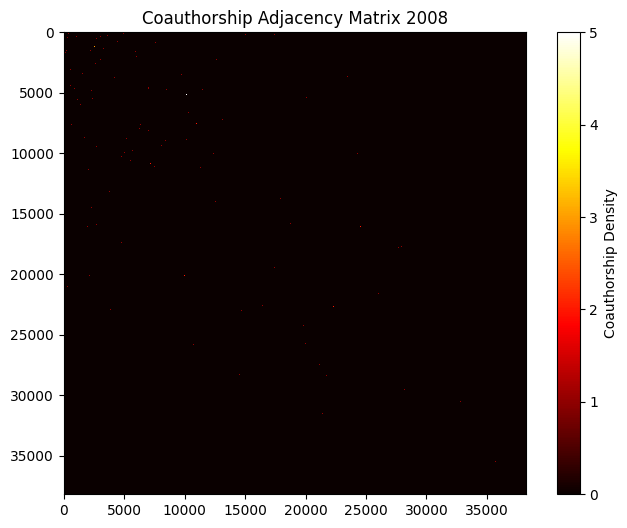

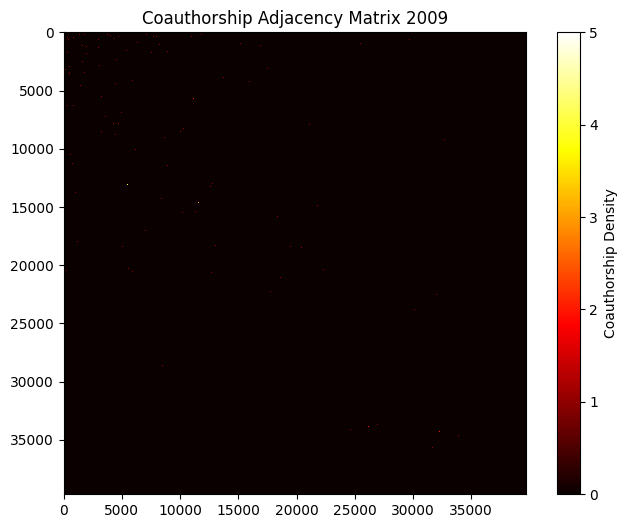

In [565]:
# 累積、上位
G=nx.Graph()
def draw_matrix(matrix):
    plt.figure(figsize=(8, 6))
    norm = Normalize(vmin=0, vmax=5, clip=True)
    plt.imshow(matrix, cmap='hot', norm= norm,interpolation='nearest')
    # plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Coauthorship Density')
    plt.title(f'Coauthorship Adjacency Matrix {year}')
    plt.grid(False)
    plt.show()
for year in year_range:
    with open(f'./result/coauth_pair_{disc}_{year}.pickle', 'rb') as f:
        coauth_pair = pickle.load(f)
    sample = res[res["year_y"]==year]
    G.add_edges_from(coauth_pair)
    edges_with_weights = [(sample.loc[i,"authid"], sample.loc[i,"source_authid"], {'weight': sample.loc[i,"year_x"]+1}) for i in sample.index]
    G.add_edges_from(edges_with_weights)
    nodes = pd.Series(list(G.nodes))
    subgraph_nodes = nodes[nodes.isin(sample["authid"].unique())]
    subgraph_nodes = pd.concat([subgraph_nodes, nodes[nodes.isin(sample["source_authid"].unique())]], axis="index")
    
    subgraph = G.subgraph(subgraph_nodes)
    adj_matrix = nx.adjacency_matrix(subgraph)
    order = np.argsort(adj_matrix.sum(axis=0))
    
    clustered_adj_matrix = adj_matrix[order[::-1], :][:, order[::-1]]
    
    # draw_matrix(adj_matrix_dense)
    draw_matrix(clustered_adj_matrix.todense())